# DSKI ML

## Imports

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import xgboost as xgb
from lazypredict.supervised import LazyClassifier
import shap
from IPython.display import Image
from sklearn import tree

In [ ]:
np.set_printoptions(suppress=True)

## Load Data

In [2]:
# Laden des Datensatzes
file_path = 'data/heart.csv'
df = pd.read_csv(file_path)

## Explorative Datenanalyse

### Basis Analyse - Datenqualität

In [3]:
# Überblick über die Daten verschaffen
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease
count 918.00     918.00       918.00     918.00 918.00   918.00        918.00
mean   53.51     132.40       198.80       0.23 136.81     0.89          0.55
std     9.43      18.51       109.38       0.42  25.46     1.07          0.50
min    28.00       0.00         0.00       0.00  60.00    -2.60          0.00
25%    47.00     120.00       173.25       0.00 120.00     0.00          0.00
50%    54.00     130.00       223.00       0.00 138.00     0.60          1.00
75%    60.00     140.00       267.00       0.00 156.00     1.50          1.00
max    77.00     200.00       603.00       1.00 202.00     6.20          1.00

In [4]:
# Überprüfung auf fehlende Werte
print("\nAnzahl fehlender Werte pro Spalte:")
print(df.isnull().sum())

# Überprüfung auf Duplikate
duplikate = df.duplicated().sum()
print(f"\nAnzahl der Duplikate: {duplikate}")

# Verteilung der Zielvariable
print("\nVerteilung der Herzerkrankungen:")
print(df['HeartDisease'].value_counts(normalize=True))


Anzahl fehlender Werte pro Spalte:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Anzahl der Duplikate: 0

Verteilung der Herzerkrankungen:
HeartDisease
1   0.55
0   0.45
Name: proportion, dtype: float64


### Visualisierung von numerischen Feature

In [5]:
# Wir filtern die numerischen Spalten heraus
numerische_spalten = df.select_dtypes(include=['float64', 'int64']).columns

#### Verteilungen der numerischen Deature

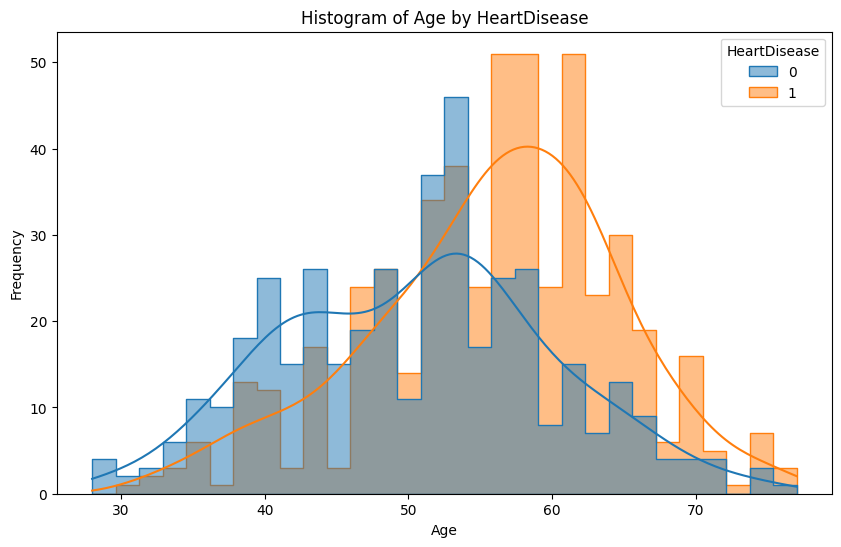

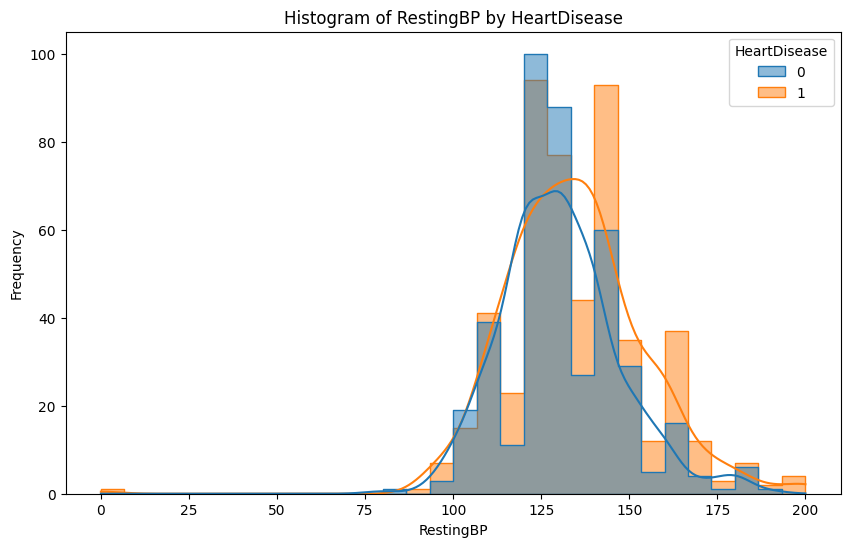

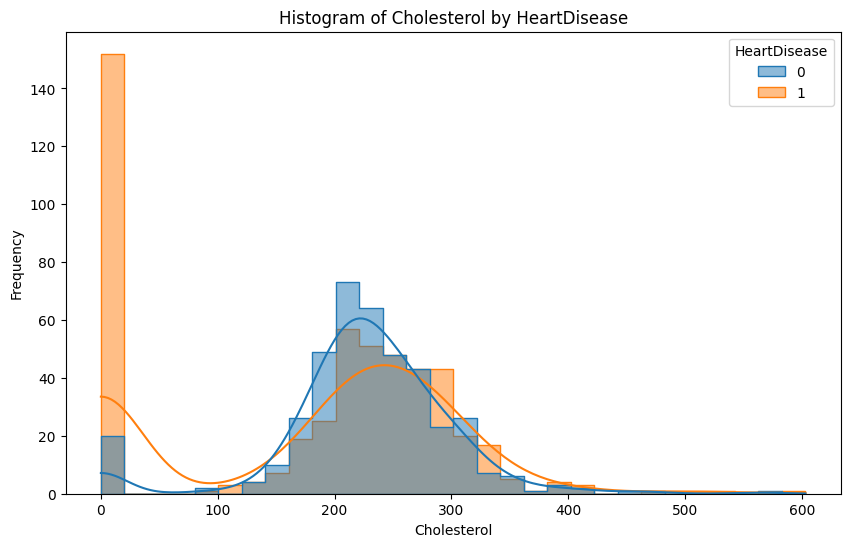

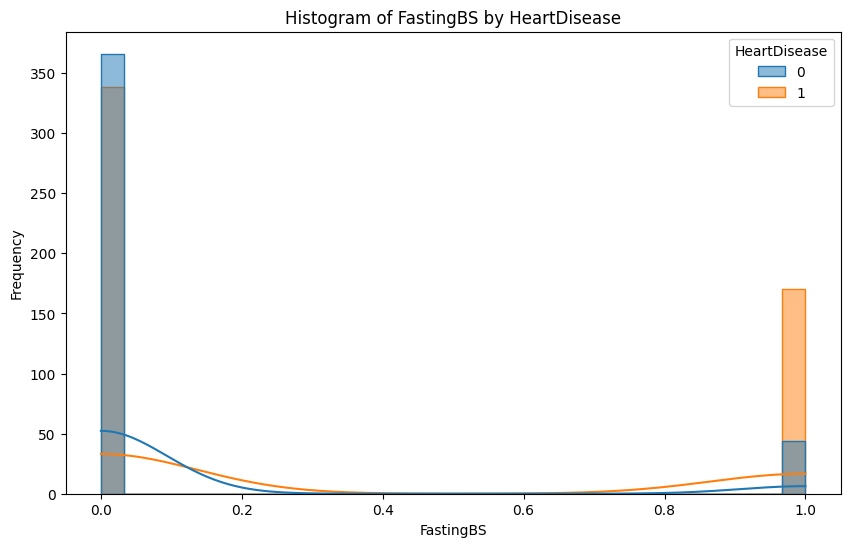

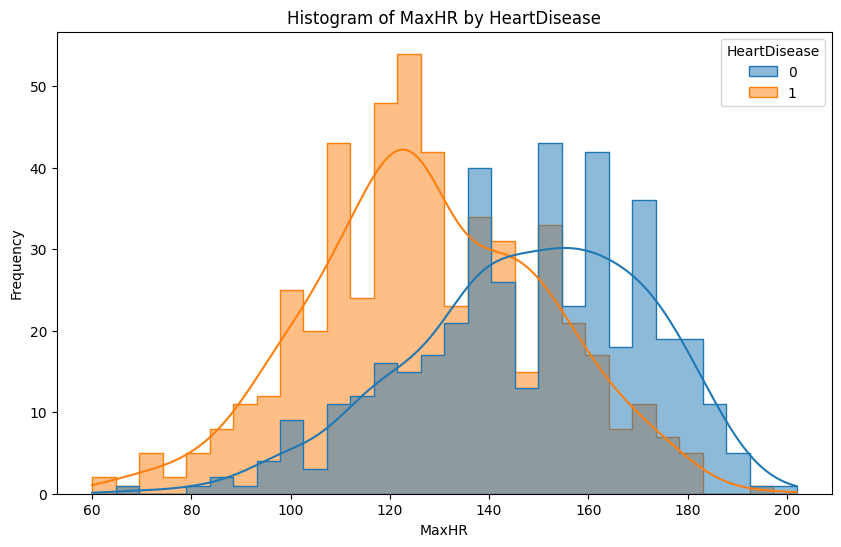

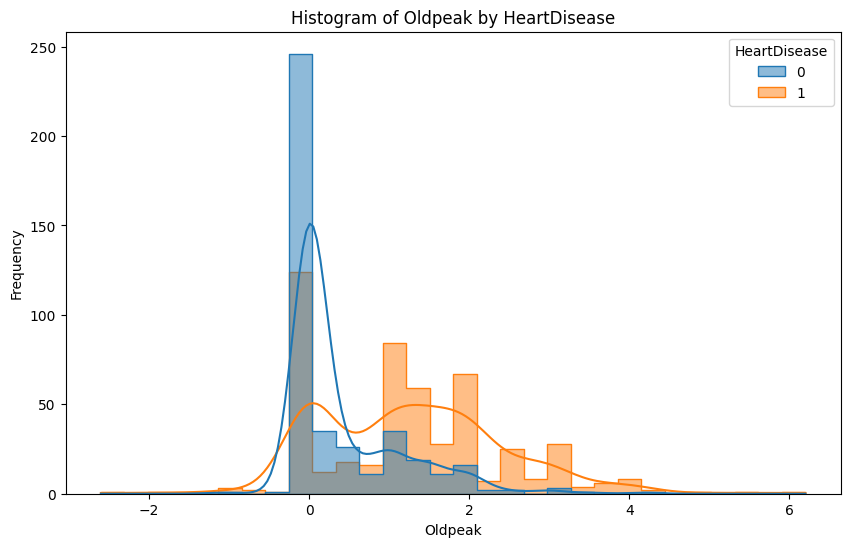

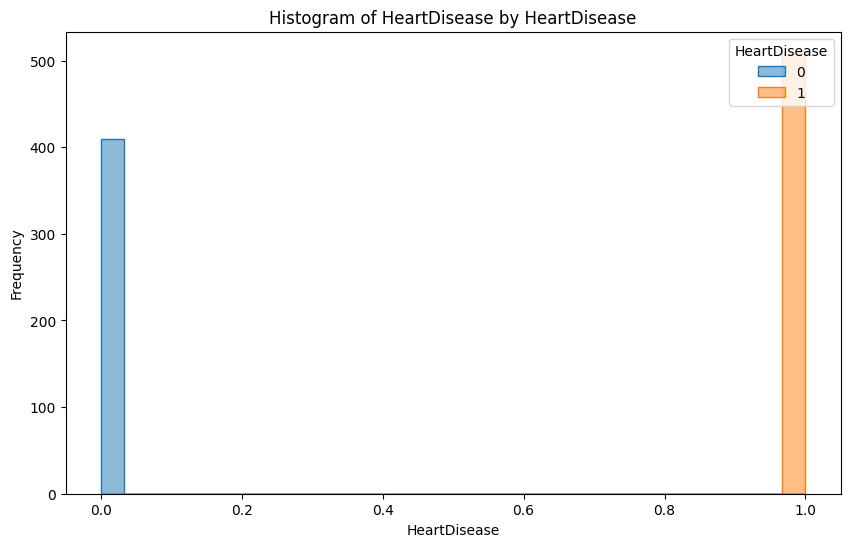

In [6]:
# Histogramme für numerische Variablen mit HeartDisease als Farbe
for column in numerische_spalten:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=column, hue='HeartDisease', bins=30, kde=True, palette='tab10', element="step", alpha=0.5)
    plt.title(f'Histogram of {column} by HeartDisease')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

#### Boxplots- Ausreißer Analyse

Da der Nüchternblutzucker(FastingBS) binäre Werte hat macht eine Boxplotdarstellung keinen Sinn (siehe .ReadMe).

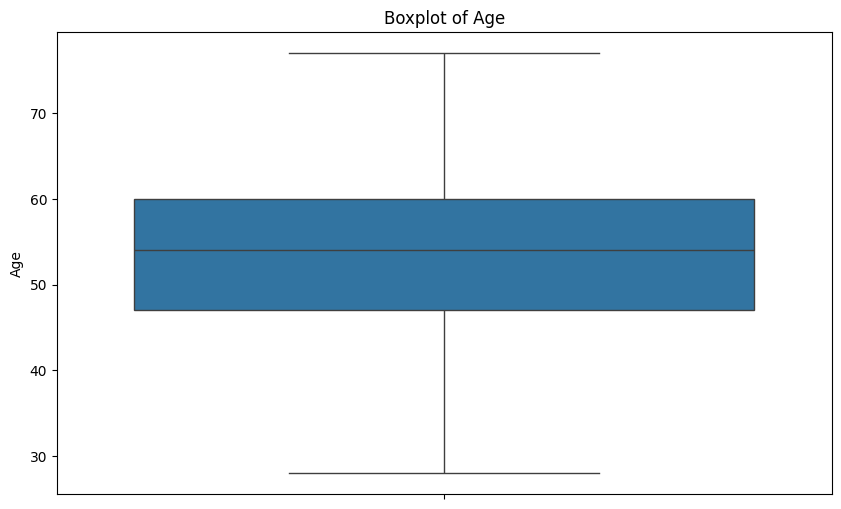

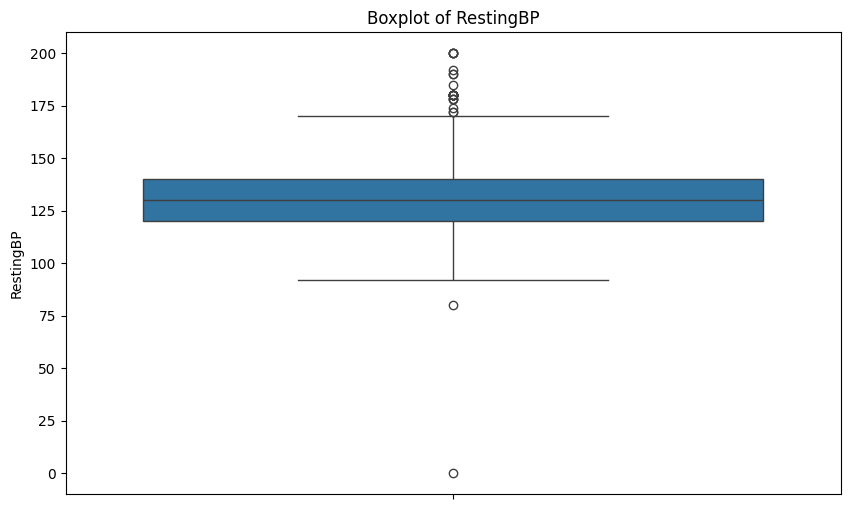

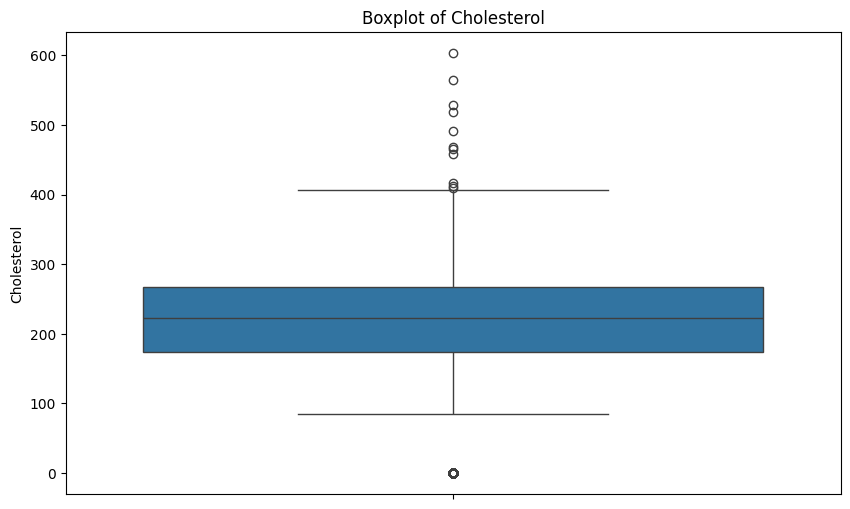

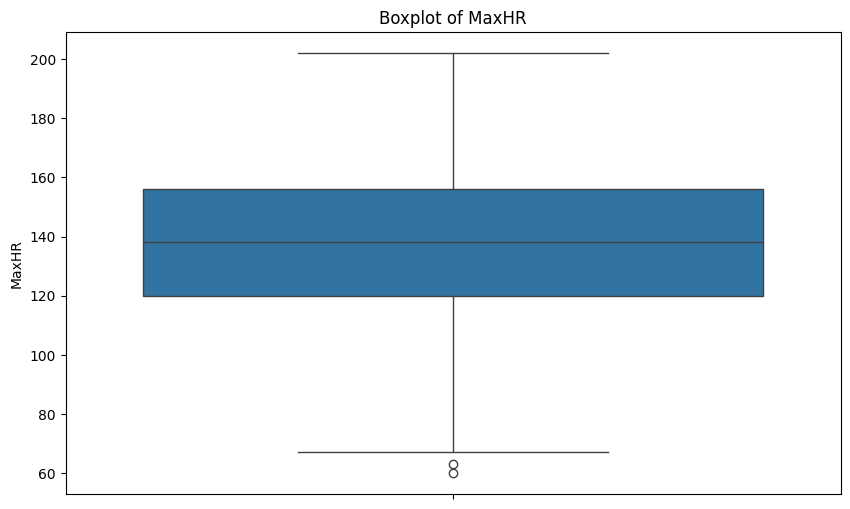

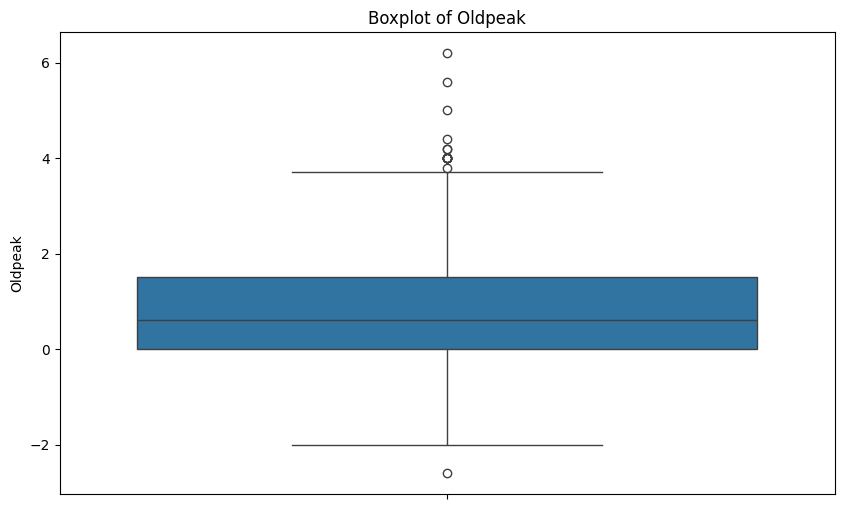

In [7]:
exclude_columns = ['FastingBS', 'HeartDisease']
boxplot_columns = [col for col in numerische_spalten if col not in exclude_columns]

for column in boxplot_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)
    plt.show()

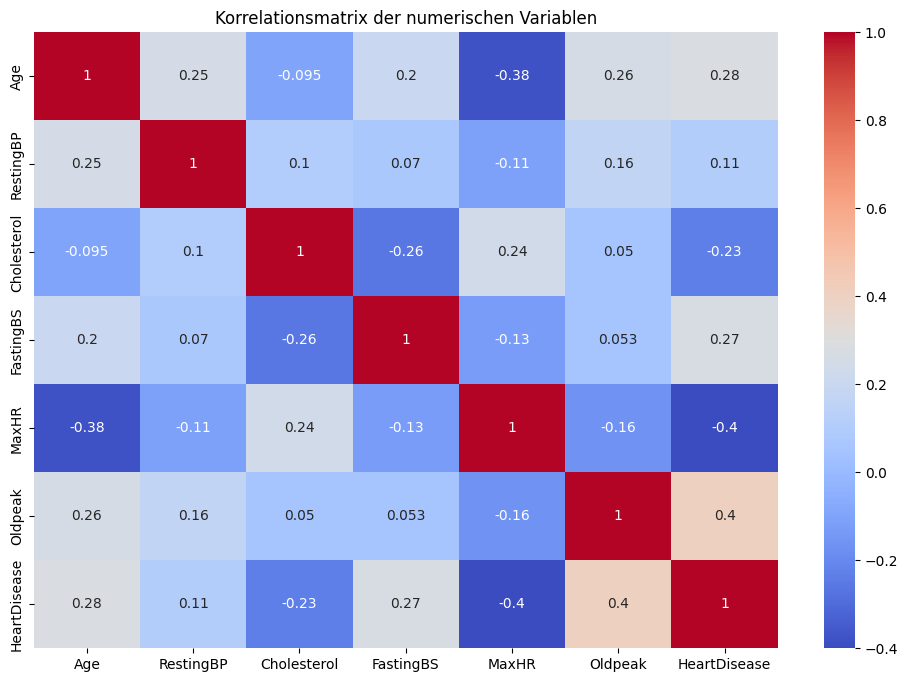

In [8]:
# Wir erstellen die Korrelationsmatrix nur für die numerischen Spalten
correlation_matrix = df[numerische_spalten].corr()

# Korrelationsmatrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Korrelationsmatrix der numerischen Variablen')
plt.show()

### Visualisierung von kategorischen Feature

#### Häufigkeitsverteilungen

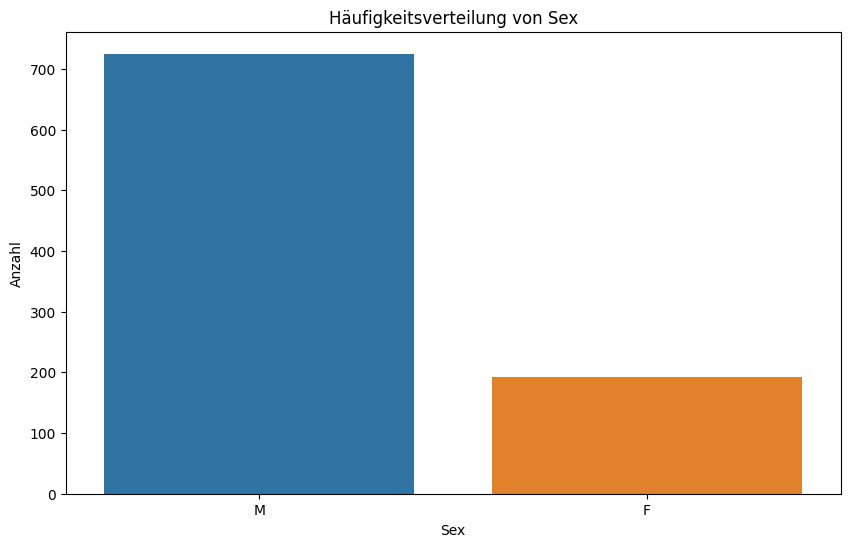

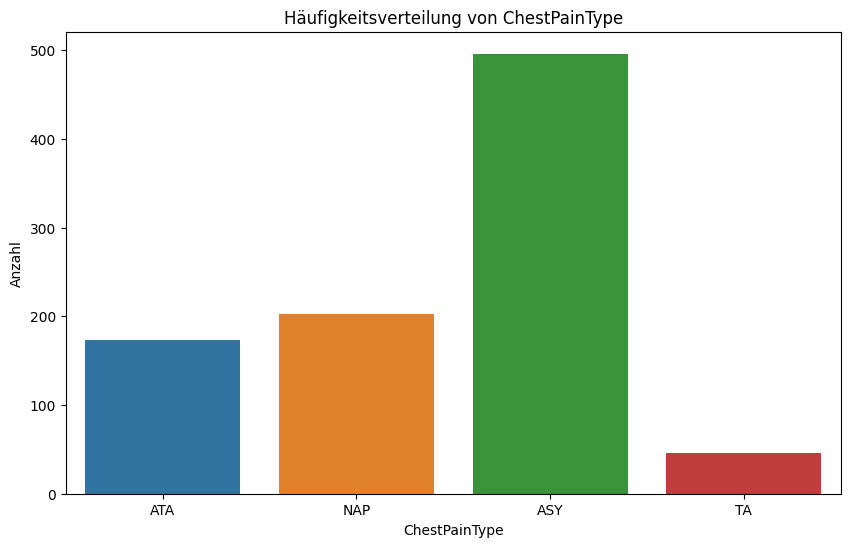

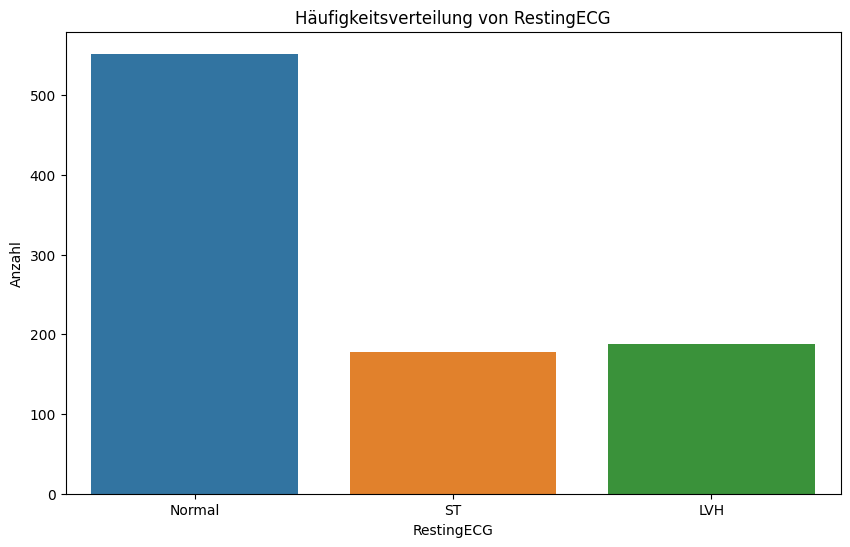

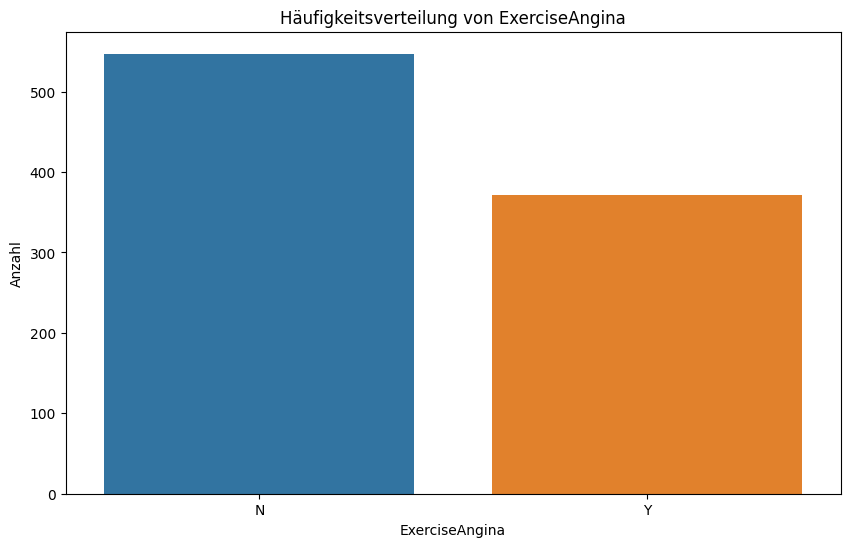

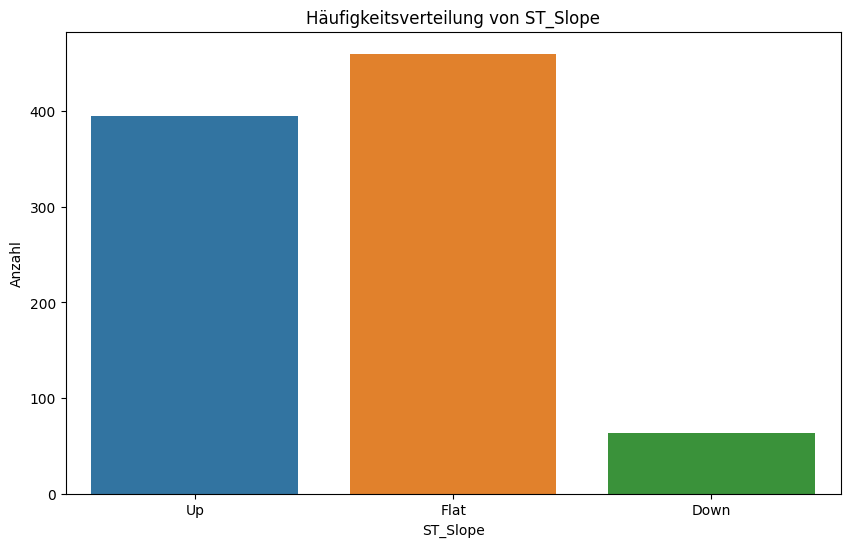

In [9]:
# Kategoriale Variablen identifizieren
kategoriale_spalten = df.select_dtypes(include=['object']).columns

# Häufigkeitsverteilungen anzeigen
for column in kategoriale_spalten:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column, palette='tab10')
    plt.title(f'Häufigkeitsverteilung von {column}')
    plt.xlabel(column)
    plt.ylabel('Anzahl')
    plt.show()


#### Häufigkeitsverteilung nach der Zielvariable

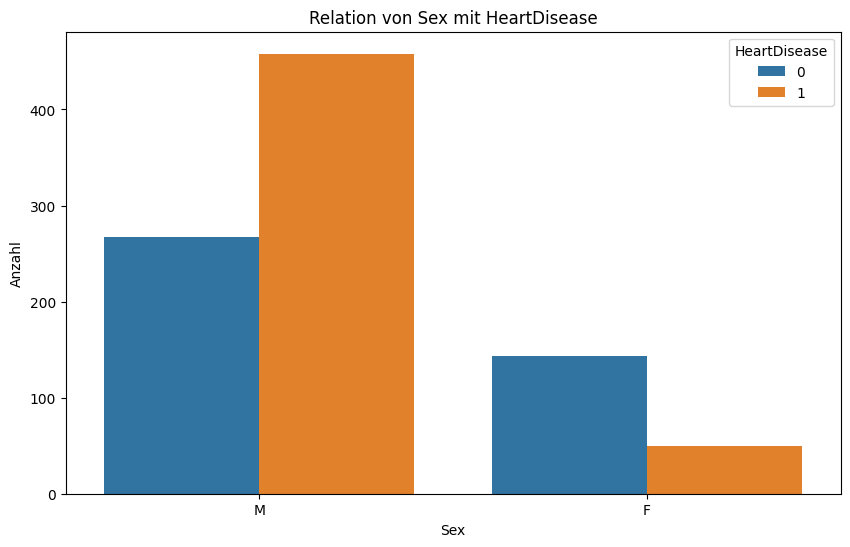

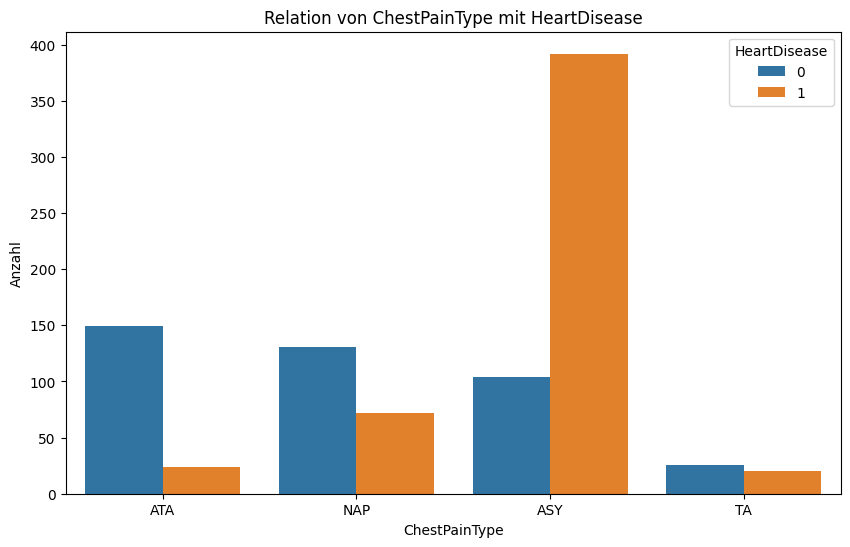

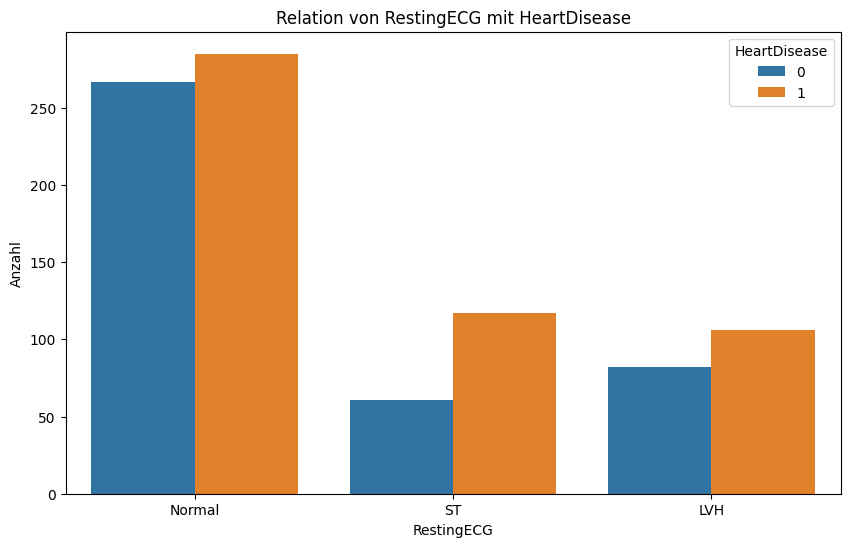

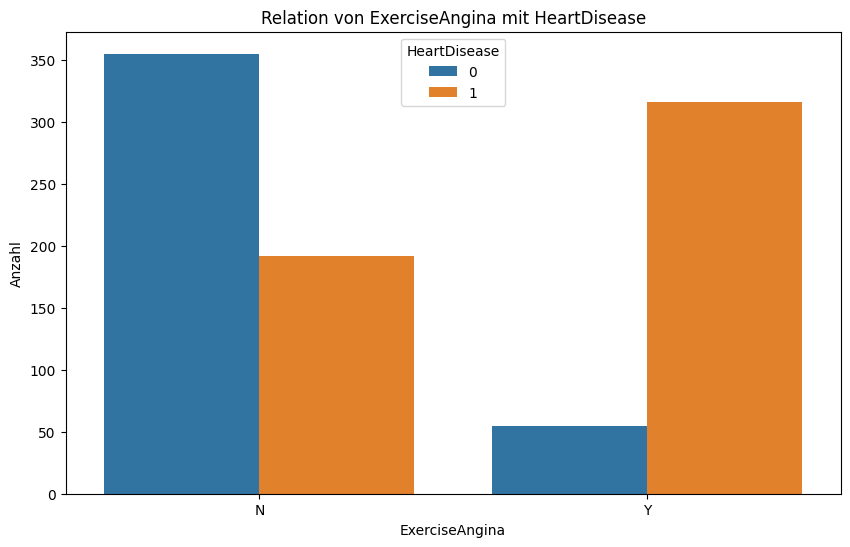

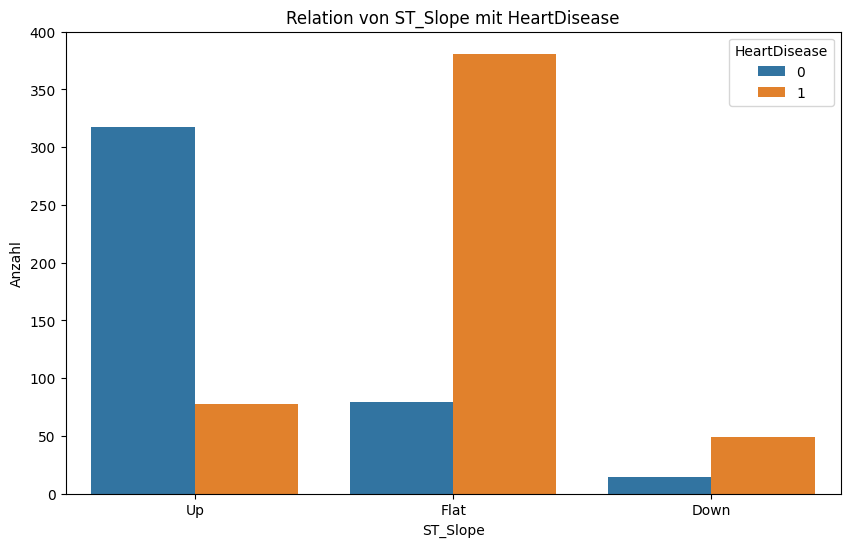

In [10]:
# Beziehung zwischen kategorialen Variablen und der Zielvariable
for column in kategoriale_spalten:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column, hue='HeartDisease', palette='tab10')
    plt.title(f'Relation von {column} mit HeartDisease')
    plt.xlabel(column)
    plt.ylabel('Anzahl')
    plt.show()


#### Tiefere Analyse der Feature

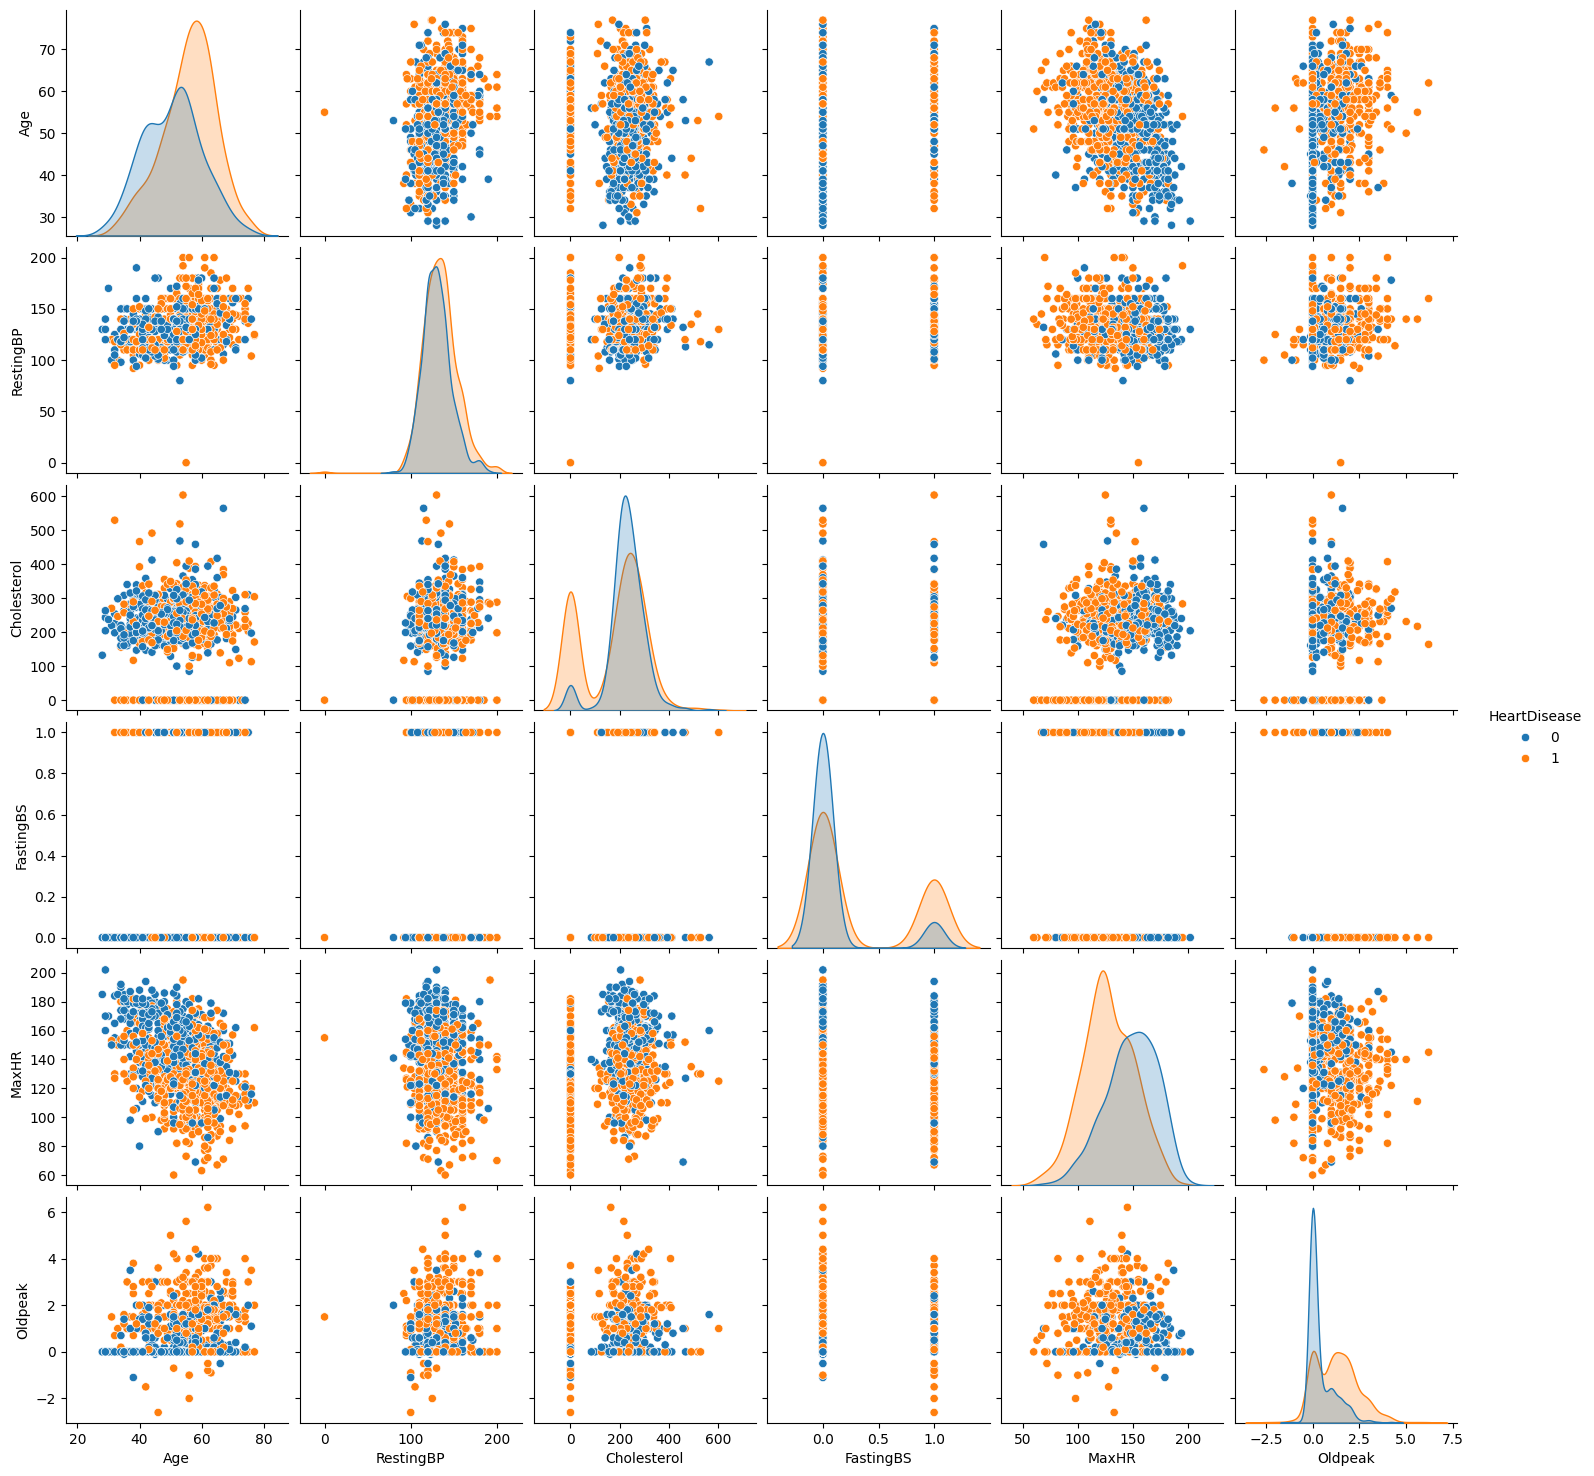

In [11]:
# Paarplot der numerischen Variablen
sns.pairplot(df, hue='HeartDisease', palette='tab10')
plt.show()

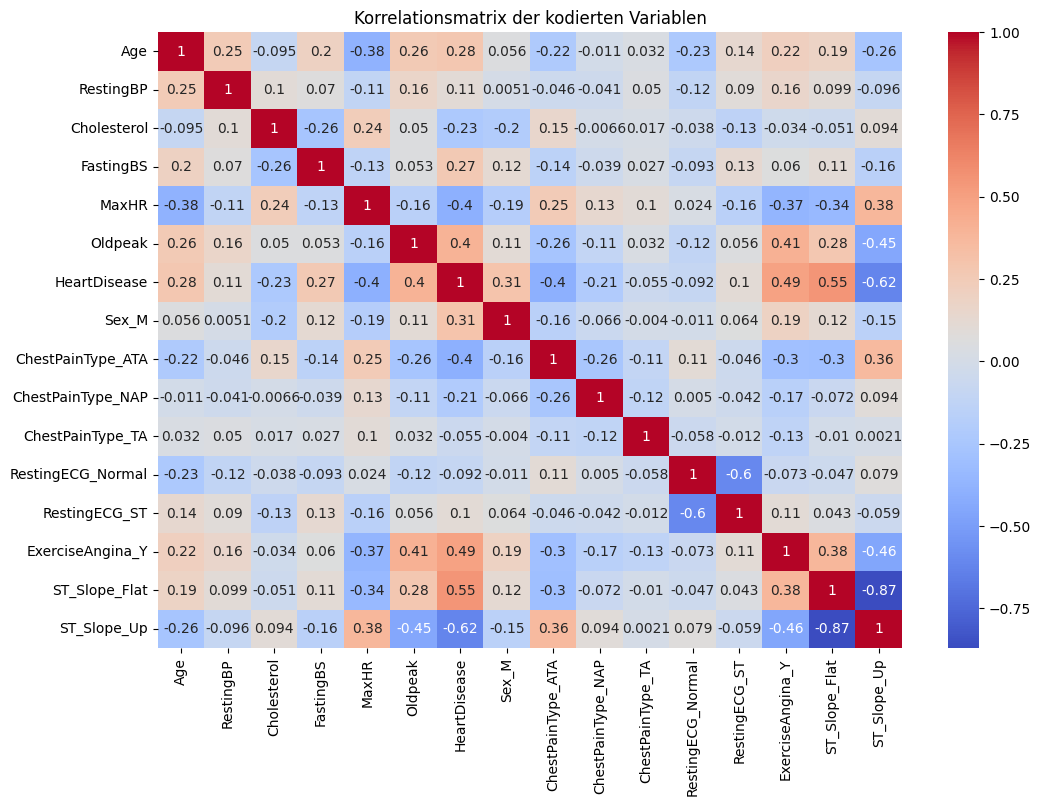

In [12]:
# Korrelationsmatrix für kategoriale Variablen
df_encoded = pd.get_dummies(df, drop_first=True)
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm')
plt.title('Korrelationsmatrix der kodierten Variablen')
plt.show()


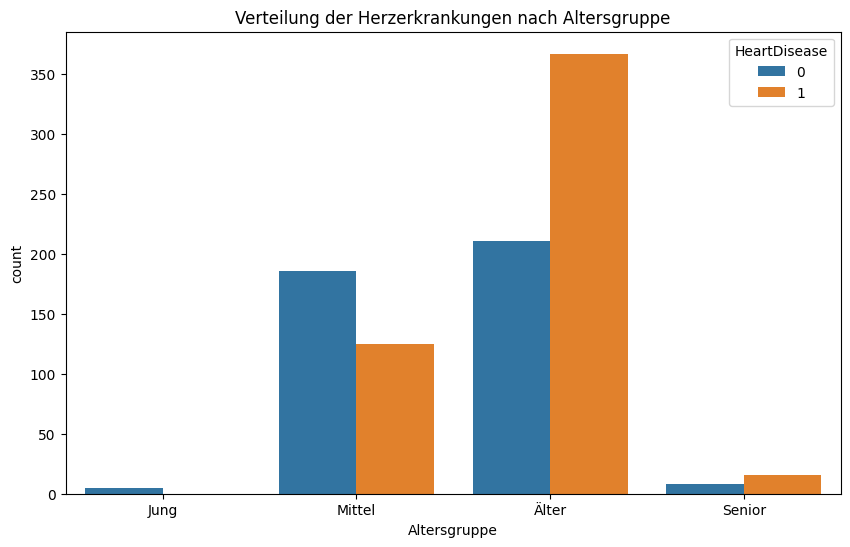

In [13]:
# Altersgruppenanalyse
ziel_variable = df['HeartDisease']

df['Altersgruppe'] = pd.cut(df['Age'], bins=[0, 30, 50, 70, 100], labels=['Jung', 'Mittel', 'Älter', 'Senior'])
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Altersgruppe', hue=ziel_variable)
plt.title('Verteilung der Herzerkrankungen nach Altersgruppe')
plt.show()


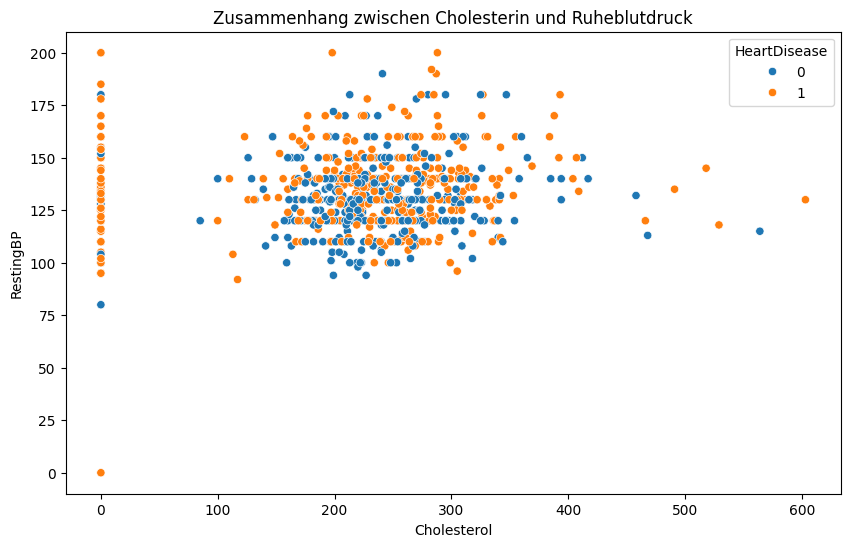

In [14]:
# Analyse des Zusammenhangs zwischen Cholesterin und Blutdruck
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Cholesterol', y='RestingBP', hue=ziel_variable)
plt.title('Zusammenhang zwischen Cholesterin und Ruheblutdruck')
plt.show()


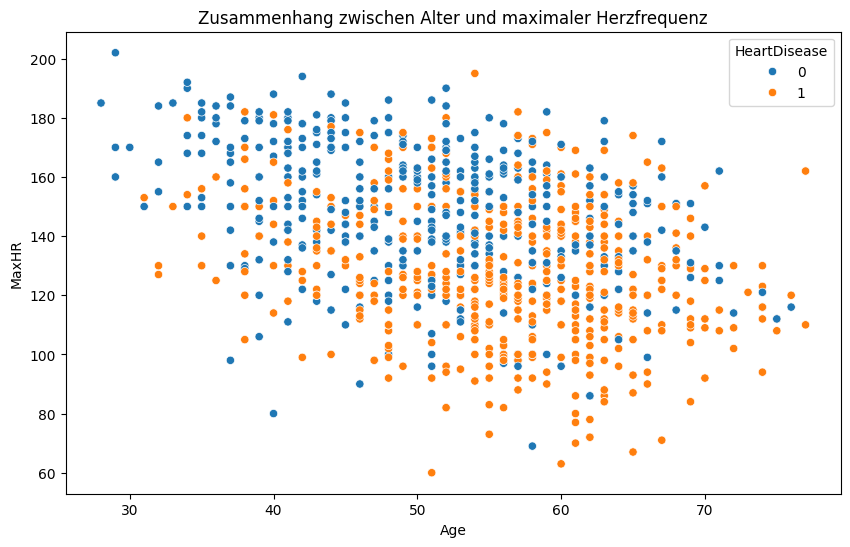

In [15]:
# Analyse des Zusammenhangs zwischen Alter und maximaler Herzfrequenz
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='MaxHR', hue=ziel_variable)
plt.title('Zusammenhang zwischen Alter und maximaler Herzfrequenz')
plt.show()

## Data Preparation 

### Datensatz überprüfen

In [16]:
# Fehlende Werte überprüfen
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
Altersgruppe      0
dtype: int64

In [17]:
df['Cholesterol'].loc[df['Cholesterol']<=20].sum()

0

In [18]:
# Duplikate überprüfen und entfernen
print(df.duplicated().sum())
df = df.drop_duplicates()
print(df.duplicated().sum())

0
0


In [19]:
# Nach Datentypen überprüfen
df.dtypes

Age                  int64
Sex                 object
ChestPainType       object
RestingBP            int64
Cholesterol          int64
FastingBS            int64
RestingECG          object
MaxHR                int64
ExerciseAngina      object
Oldpeak            float64
ST_Slope            object
HeartDisease         int64
Altersgruppe      category
dtype: object

### Feature Engineering

We have 2 options for data scaling : 1) Normalization 2) Standardization. As most of the algorithms assume the data to be normally (Gaussian) distributed, Normalization is done for features whose data does not display normal distribution and standardization is carried out for features that are normally distributed where their values are huge or very small as compared to other features.
Normalization : Oldpeak feature is normalized as it had displayed a right skewed data distribution.
Standardizarion : Age, RestingBP, Cholesterol and MaxHR features are scaled down because these features are normally distributed.


https://www.kaggle.com/code/tanmay111999/heart-failure-prediction-cv-score-90-5-models#Feature-Engineering

#### Altersgruppen bilden

In [20]:
# Feature Erstellung und Transformation
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 30, 50, 100], labels=['Young', 'Middle-aged', 'Senior'])


#### Gruppen für Olpeak

In [21]:
# Oldpeak in Bins einteilen
bins = [-1, 0, 2, 4, float('inf')]
labels = ['Normal', 'Mild', 'Moderate', 'Severe']
df['OldpeakBinned'] = pd.cut(df['Oldpeak'], bins=bins, labels=labels)

#### Auswahl der Features

In [22]:
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'AgeGroup', 'OldpeakBinned']
numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

#### Einstellung des Preprocessing

In [23]:
# Numerische Features aufteilen
features_to_normalize = ['Oldpeak']
features_to_standardize = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']
other_numeric_features = ['FastingBS']

# Pipeline für zu normalisierende Features
normalize_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('normalizer', MinMaxScaler())
])

# Pipeline für zu standardisierende Features
standardize_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline für andere numerische Features
other_numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Preprocessing Pipeline für kategorische Daten (unverändert)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Kombination der Preprocessing Schritte
preprocessor = ColumnTransformer(
    transformers=[
        ('normalize', normalize_transformer, features_to_normalize),
        ('standardize', standardize_transformer, features_to_standardize),
        ('other_num', other_numeric_transformer, other_numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#### Anwendung des preprocessing für Übersicht und Debugging

In [24]:
# Anwenden des Preprocessings
X = preprocessor.fit_transform(df)

# Erstellen eines neuen DataFrames mit den transformierten Daten
numeric_feature_names = features_to_normalize + features_to_standardize + other_numeric_features
categorical_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
feature_names = numeric_feature_names + categorical_feature_names

df_transformed = pd.DataFrame(X, columns=feature_names)

# Hinzufügen der Zielvariable
df_transformed['HeartDisease'] = df['HeartDisease']

In [25]:
df_transformed.head()

Oldpeak   Age  RestingBP  Cholesterol  MaxHR  FastingBS  Sex_F  Sex_M  \
0     0.30 -1.43       0.41         0.83   1.38       0.00   0.00   1.00   
1     0.41 -0.48       1.49        -0.17   0.75       0.00   1.00   0.00   
2     0.30 -1.75      -0.13         0.77  -1.53       0.00   0.00   1.00   
3     0.47 -0.58       0.30         0.14  -1.13       0.00   1.00   0.00   
4     0.30  0.05       0.95        -0.03  -0.58       0.00   0.00   1.00   

   ChestPainType_ASY  ChestPainType_ATA  ...  ST_Slope_Flat  ST_Slope_Up  \
0               0.00               1.00  ...           0.00         1.00   
1               0.00               0.00  ...           1.00         0.00   
2               0.00               1.00  ...           0.00         1.00   
3               1.00               0.00  ...           1.00         0.00   
4               0.00               0.00  ...           0.00         1.00   

   AgeGroup_Middle-aged  AgeGroup_Senior  AgeGroup_Young  OldpeakBinned_Mild  \
0                  1.00             0.00            0.00                0.00   
1                  1.00             0.00            0.00                1.00   
2                  1.00             0.00            0.00                0.00   
3                  1.00             0.00            0.00                1.00   
4                  0.00             1.00            0.00                0.00   

   OldpeakBinned_Moderate  OldpeakBinned_Normal  OldpeakBinned_Severe  \
0                    0.00                  1.00                  0.00   
1                    0.00                  0.00                  0.00   
2                    0.00                  1.00                  0.00   
3                    0.00                  0.00                  0.00   
4                    0.00                  1.00                  0.00   

   HeartDisease  
0             0  
1             1  
2             0  
3             1  
4             0  

[5 rows x 28 columns]

#### Preprocessed Features Analyse

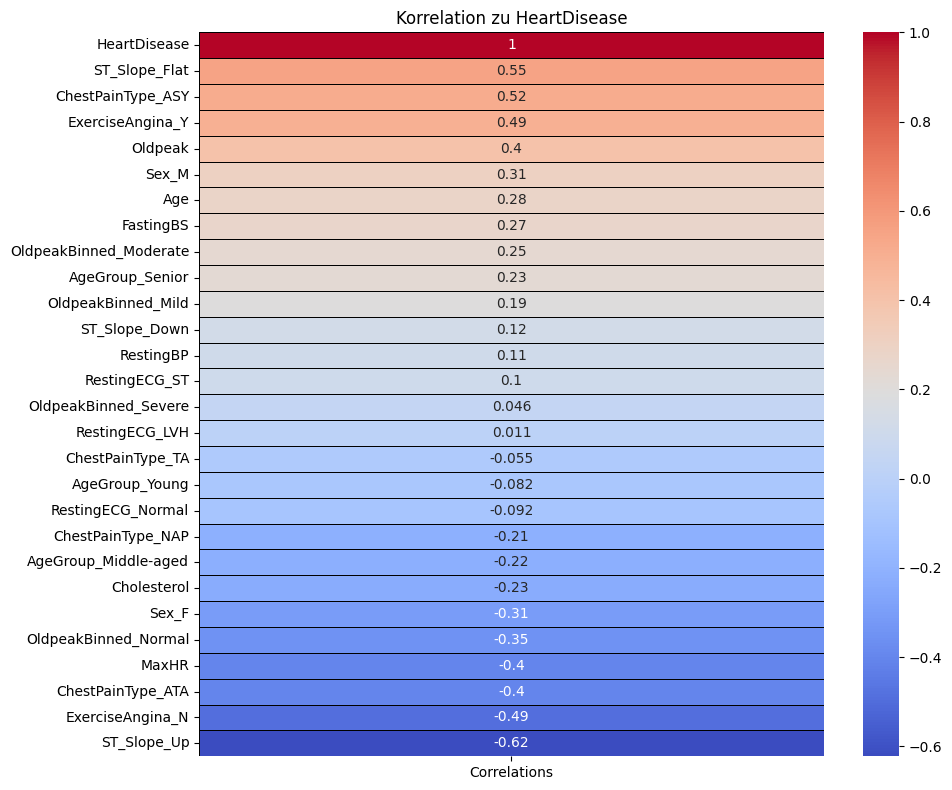

In [26]:
# Berechnung der Korrelationen
corr = df_transformed.corrwith(df_transformed['HeartDisease']).sort_values(ascending=False).to_frame()
corr.columns = ['Correlations']

# Visualisierung
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.4, linecolor='black')
plt.title('Korrelation zu HeartDisease')
plt.tight_layout()
plt.show()

### Trainings- und Testdatensätze

In [27]:
# Aufteilen der Daten in Trainings- und Testdatensätze
X = df_transformed.drop('HeartDisease', axis=1)
y = df_transformed['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modelle
### LazyPredict

In [28]:
lazy_clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, random_state=42)
models, predictions = lazy_clf.fit(X_train, X_test, y_train, y_test )

100%|██████████| 29/29 [00:02<00:00, 12.46it/s]

[LightGBM] [Info] Number of positive: 401, number of negative: 333
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 734, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546322 -> initscore=0.185819
[LightGBM] [Info] Start training from score 0.185819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [29]:
print(models)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.88               0.88     0.88      0.88   
SVC                                0.87               0.87     0.87      0.87   
XGBClassifier                      0.86               0.86     0.86      0.86   
RandomForestClassifier             0.86               0.86     0.86      0.86   
BaggingClassifier                  0.85               0.86     0.86      0.85   
KNeighborsClassifier               0.85               0.85     0.85      0.85   
AdaBoostClassifier                 0.85               0.85     0.85      0.85   
RidgeClassifierCV                  0.85               0.85     0.85      0.85   
RidgeClassifier                    0.85               0.85     0.85      0.85   
LinearDiscriminantAnalysis         0.84               0.85     0.85      0.84   
NuSVC                       

### DecisionTree

In [31]:
decision_tree_clf = DecisionTreeClassifier(random_state=42)
decision_tree_clf.fit(X_train, y_train)

y_pred = decision_tree_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.7608695652173914


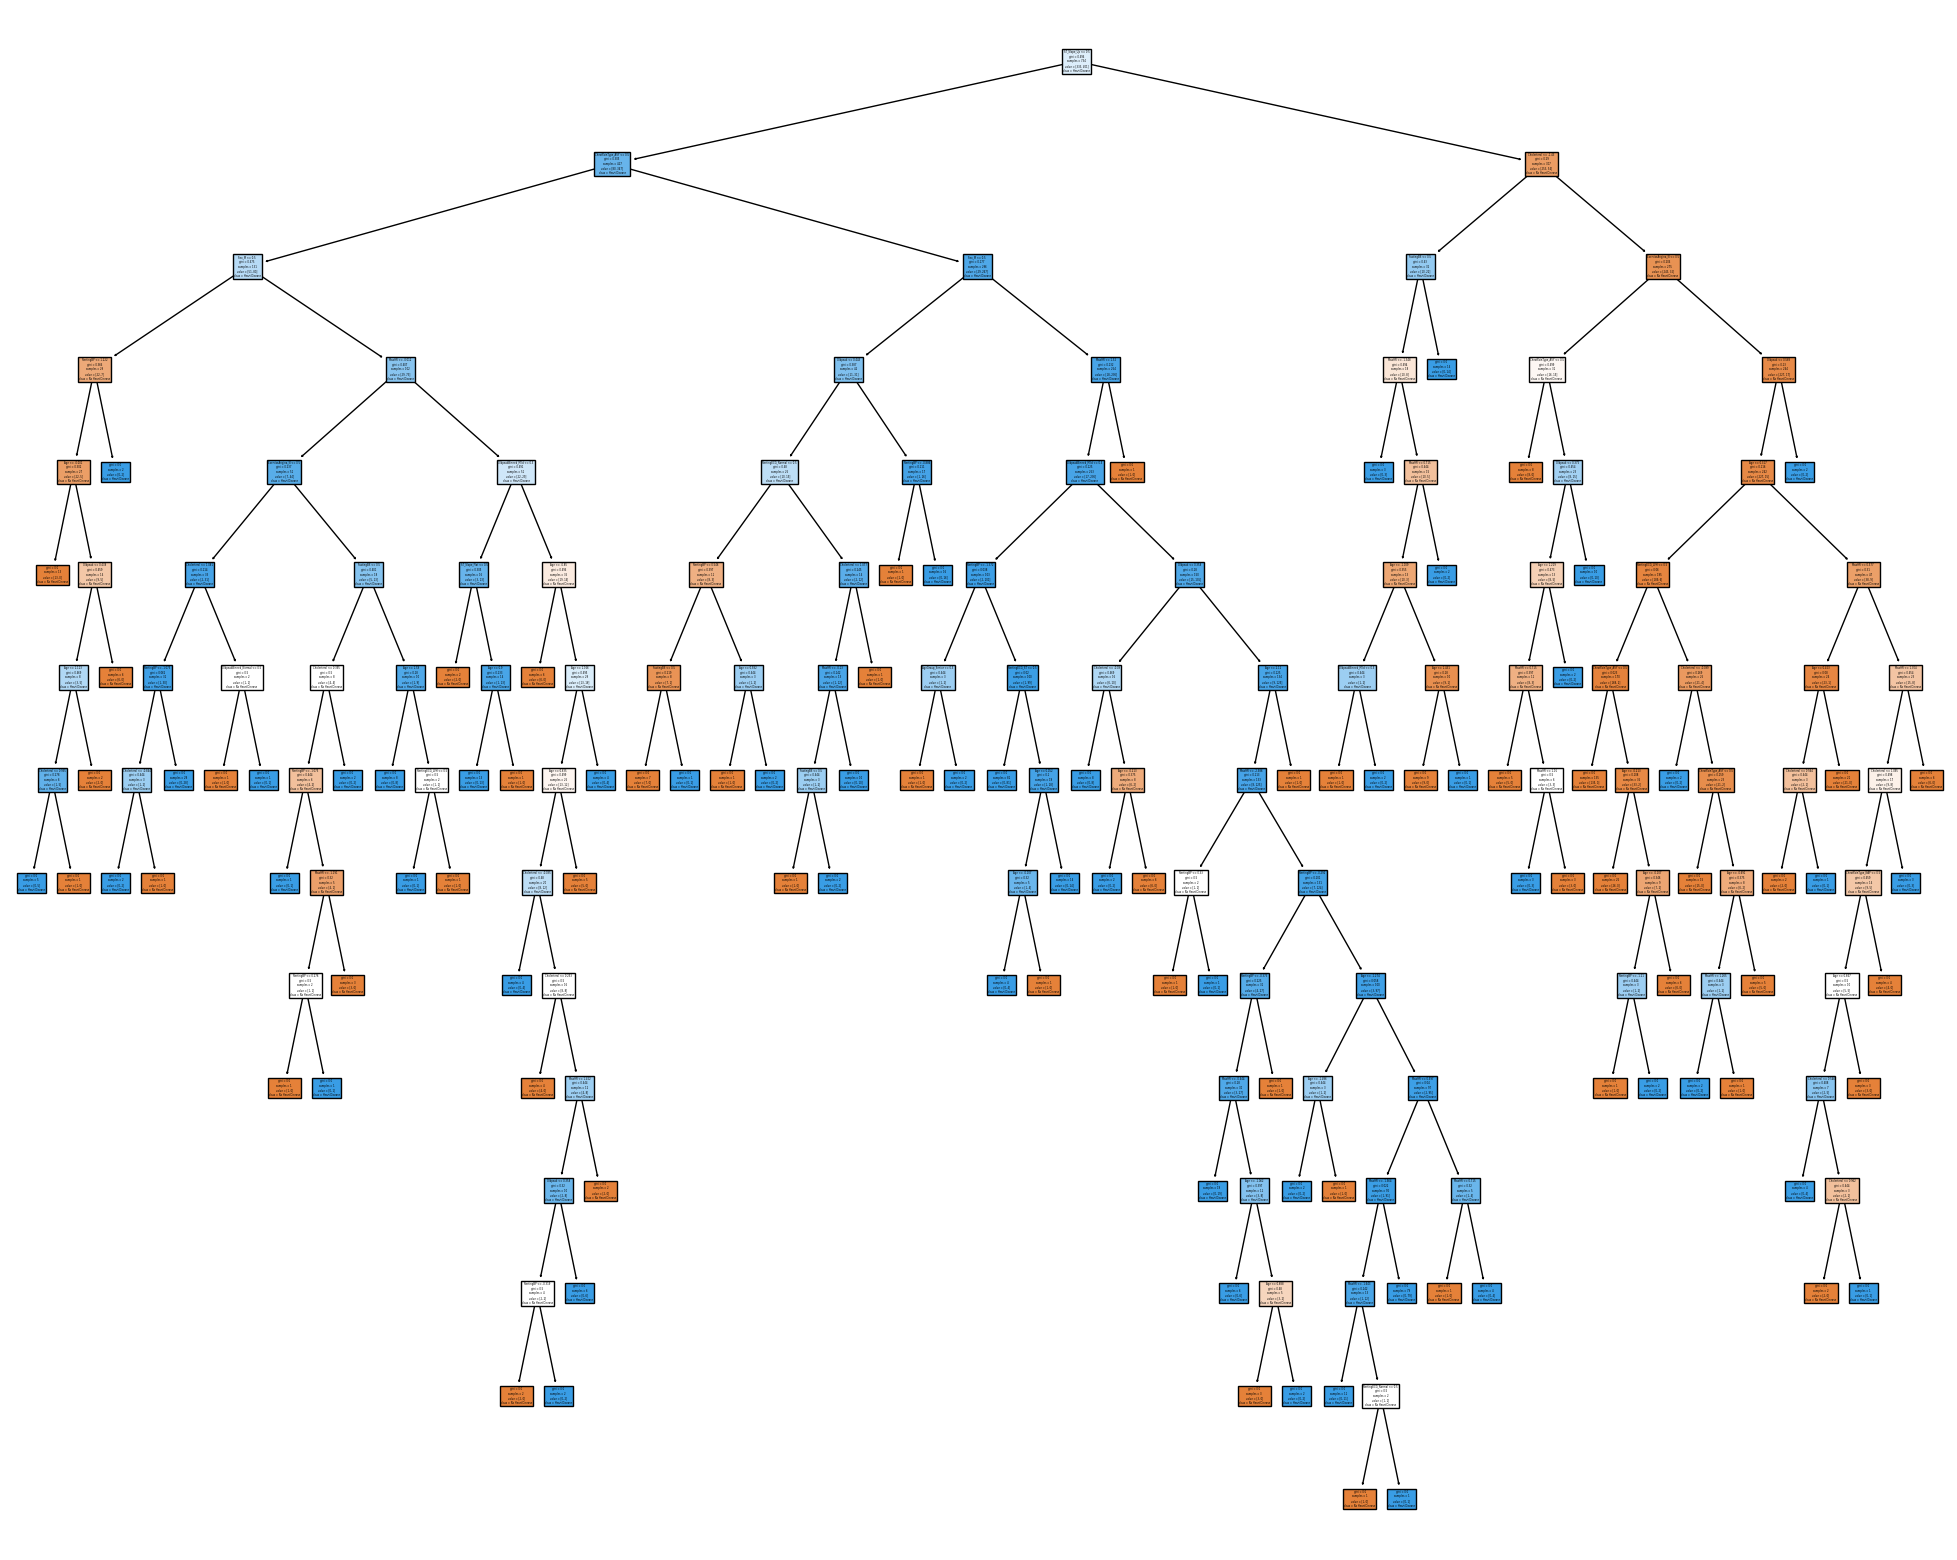

In [43]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree_clf,
                   feature_names=X.columns,
                   class_names=['No Heart Disease', 'Heart Disease'],
                   filled=True)
fig.savefig('decisiontree.png')

In [46]:
X_train

Oldpeak   Age  RestingBP  Cholesterol  MaxHR  FastingBS  Sex_F  Sex_M  \
795     0.39 -1.22      -0.67         0.38   2.25       1.00   0.00   1.00   
25      0.30 -1.86      -0.13         0.09   1.62       0.00   0.00   1.00   
84      0.41  0.26       0.95         0.13  -0.46       1.00   0.00   1.00   
10      0.30 -1.75      -0.13         0.11   0.20       0.00   1.00   0.00   
344     0.30 -0.27      -0.67        -1.82  -1.29       1.00   0.00   1.00   
..       ...   ...        ...          ...    ...        ...    ...    ...   
106     0.30 -0.58      -0.67         0.50  -1.05       0.00   1.00   0.00   
270     0.30 -0.90      -0.67         0.24   0.13       0.00   0.00   1.00   
860     0.45  0.69      -0.13         0.50   0.28       0.00   0.00   1.00   
435     0.30  0.69       1.06        -1.82  -0.74       0.00   0.00   1.00   
102     0.52 -1.43       0.95         1.77  -0.27       0.00   1.00   0.00   

     ChestPainType_ASY  ChestPainType_ATA  ...  ST_Slope_Down  ST_Slope_Flat  \
795               0.00               0.00  ...           1.00           0.00   
25                0.00               0.00  ...           0.00           0.00   
84                1.00               0.00  ...           0.00           1.00   
10                0.00               0.00  ...           0.00           0.00   
344               1.00               0.00  ...           0.00           1.00   
..                 ...                ...  ...            ...            ...   
106               1.00               0.00  ...           0.00           0.00   
270               1.00               0.00  ...           0.00           0.00   
860               1.00               0.00  ...           0.00           0.00   
435               1.00               0.00  ...           0.00           0.00   
102               1.00               0.00  ...           0.00           1.00   

     ST_Slope_Up  AgeGroup_Middle-aged  AgeGroup_Senior  AgeGroup_Young  \
795         0.00                  1.00             0.00            0.00   
25          1.00                  1.00             0.00            0.00   
84          0.00                  0.00             1.00            0.00   
10          1.00                  1.00             0.00            0.00   
344         0.00                  0.00             1.00            0.00   
..           ...                   ...              ...             ...   
106         1.00                  1.00             0.00            0.00   
270         1.00                  1.00             0.00            0.00   
860         1.00                  0.00             1.00            0.00   
435         1.00                  0.00             1.00            0.00   
102         0.00                  1.00             0.00            0.00   

     OldpeakBinned_Mild  OldpeakBinned_Moderate  OldpeakBinned_Normal  \
795                1.00                    0.00                  0.00   
25                 0.00                    0.00                  1.00   
84                 1.00                    0.00                  0.00   
10                 0.00                    0.00                  1.00   
344                0.00                    0.00                  1.00   
..                  ...                     ...                   ...   
106                0.00                    0.00                  1.00   
270                0.00                    0.00                  1.00   
860                1.00                    0.00                  0.00   
435                0.00                    0.00                  1.00   
102                1.00                    0.00                  0.00   

     OldpeakBinned_Severe  
795                  0.00  
25                   0.00  
84                   0.00  
10                   0.00  
344                  0.00  
..                    ...  
106                  0.00  
270                  0.00  
860                  0.00  
435                  0.00  
102                  

### SelectKBest

In [70]:
# Feature Selection
pipeline = Pipeline([
    ('scaler', StandardScaler()),             # Preprocessing: Daten skalieren
    ('feature_selection', SelectKBest(f_classif, k=3)),  # Feature Selection: Die zwei besten Features auswählen
    ('classifier', RandomForestClassifier())  # Klassifikator: RandomForest
])

# Pipeline trainieren
pipeline.fit(X_train, y_train)

# Ausgewählte Features bekommen
selected_features_bool = pipeline.named_steps['feature_selection'].get_support()
selected_features_scores = pipeline.named_steps['feature_selection'].scores_

# Namen der ausgewählten Features extrahieren (wenn die Feature-Namen bekannt sind)
feature_names = X.columns
selected_feature_names = [feature_names[i] for i in range(len(feature_names)) if selected_features_bool[i]]

print("Ausgewählte Features:", selected_feature_names)
print("Scores der Features:", np.round(selected_features_scores, 2))

Ausgewählte Features: ['ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']
Scores der Features: [159.28  72.08  14.34  49.59 152.01  52.88  82.64  82.64 236.68 137.52
  28.84   1.6    0.23   6.35   6.96 278.62 278.62  10.57 340.98 484.01
  44.73  48.28   3.64  26.7   56.33 113.81   2.01]


### Mutual Information

In [75]:
discrete_features = X.dtypes == float

In [76]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

Cholesterol              0.22
MaxHR                    0.16
ExerciseAngina_Y         0.13
Age                      0.07
Sex_M                    0.05
OldpeakBinned_Moderate   0.04
ChestPainType_NAP        0.02
RestingECG_ST            0.01
ChestPainType_TA         0.00
Name: MI Scores, dtype: float64

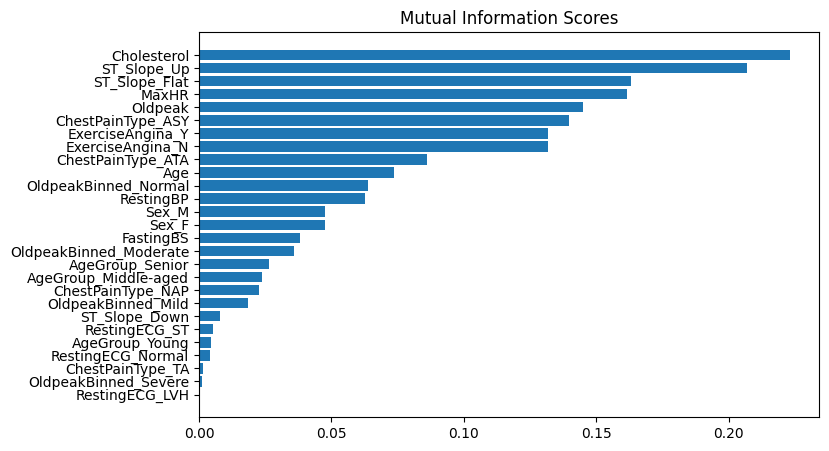

In [77]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

### Definition

In [717]:
# Modelle definieren
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier()
}

### Hyperparameter 

In [718]:
param_dists = {
    'Logistic Regression': {
        'C': np.logspace(-4, 4, 20),
        'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Support Vector Machine': {
        'C': np.logspace(-3, 3, 7),
        'gamma': np.logspace(-3, 3, 7),
        'kernel': ['rbf', 'poly', 'sigmoid']
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'min_child_weight': [1, 3, 5]
    }
}

### Random und Grid Search

In [719]:
def random_grid_search_cv(models, param_dists, X_train, y_train, n_splits=5, n_iter=30):
    best_estimators = {}
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for name, model in models.items():
        print(f"Processing {name}...")
        
        # Berechne die Gesamtzahl der Parameterkombinationen
        n_combinations = np.prod([len(v) for v in param_dists[name].values()])
        
        # Passe n_iter an, wenn nötig
        actual_n_iter = min(n_iter, n_combinations)
        
        # Randomized Search mit Cross-Validation
        random_search = RandomizedSearchCV(model, param_dists[name], n_iter=actual_n_iter, cv=kf, n_jobs=-1, random_state=42, scoring='accuracy')
        random_search.fit(X_train, y_train)
        
        # Grid Search mit den besten Parametern aus Randomized Search
        best_params = random_search.best_params_
        refined_params = {k: [v] if not isinstance(v, list) else v for k, v in best_params.items()}
        grid_search = GridSearchCV(model, refined_params, cv=kf, n_jobs=-1, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        
        best_estimators[name] = grid_search.best_estimator_
        
        # Cross-Validation Score
        cv_scores = cross_val_score(best_estimators[name], X_train, y_train, cv=kf, scoring='accuracy')
        
        print(f"Best Model: {name}")
        print("Best Parameters:", grid_search.best_params_)
        print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        print("\n")
    
    return best_estimators

### Training

In [720]:
best_models = random_grid_search_cv(models, param_dists, X_train, y_train)


Processing Logistic Regression...


/Users/noah/anaconda3/envs/dski_ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/noah/anaconda3/envs/dski_ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/noah/anaconda3/envs/dski_ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Model: Logistic Regression
Best Parameters: {'C': 0.08858667904100823, 'solver': 'newton-cg'}
Cross-Validation Accuracy: 0.8624 (+/- 0.0549)


Processing Random Forest...
Best Model: Random Forest
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Cross-Validation Accuracy: 0.8692 (+/- 0.0552)


Processing Support Vector Machine...
Best Model: Support Vector Machine
Best Parameters: {'C': 100.0, 'gamma': 0.001, 'kernel': 'rbf'}
Cross-Validation Accuracy: 0.8651 (+/- 0.0451)


Processing Gradient Boosting...
Best Model: Gradient Boosting
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Cross-Validation Accuracy: 0.8597 (+/- 0.0714)


Processing XGBoost...
Best Model: XGBoost
Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 50}
Cross-Validation Accuracy: 0.8637 (+/- 0.0674)




## Evaluation

### Funktionen

In [721]:
def plot_confusion_matrix_plotly(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    
    # Erstellen der Heatmap mit Plotly
    fig = px.imshow(cm,
                    labels=dict(x="Predicted label", y="True label"),
                    x=['Negative', 'Positive'],
                    y=['Negative', 'Positive'],
                    title=f'Confusion Matrix - {model_name}',
                    color_continuous_scale='Blues',
                    text_auto=True)
    
    fig.update_layout(width=600, height=500)
    return fig

In [722]:
def plot_model_comparison_plotly(accuracies):
    # Erstellen des Balkendiagramms mit Plotly
    fig = go.Figure(data=[go.Bar(
        x=list(accuracies.keys()),
        y=list(accuracies.values()),
        text=[f'{acc:.2f}' for acc in accuracies.values()],
        textposition='auto',
    )])
    
    fig.update_layout(
        title='Model Comparison - Test Accuracy',
        xaxis_title='Models',
        yaxis_title='Accuracy',
        yaxis_range=[0, 1],  # Setzt die y-Achse von 0 bis 1 für Genauigkeiten
        width=800,
        height=500
    )
    
    return fig

In [723]:
def plot_roc_curves(models, X_test, y_test):
    fig = go.Figure()
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = auc(fpr, tpr)
        
        fig.add_trace(go.Scatter(x=fpr, y=tpr,
                                 mode='lines',
                                 name=f'{name} (AUC = {auc_score:.3f})'))
    
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1],
                             mode='lines',
                             name='Random Classifier',
                             line=dict(dash='dash', color='grey')))
    
    fig.update_layout(title='ROC Curves',
                      xaxis_title='False Positive Rate',
                      yaxis_title='True Positive Rate',
                      legend_title='Models',
                      width=800, height=600)
    
    return fig



In [724]:
def plot_model_comparison_plotly(accuracies, auc_scores):
    fig = go.Figure()
    
    # Accuracy bars
    fig.add_trace(go.Bar(
        x=list(accuracies.keys()),
        y=list(accuracies.values()),
        name='Accuracy',
        text=[f'{acc:.3f}' for acc in accuracies.values()],
        textposition='auto',
    ))
    
    # AUC bars
    fig.add_trace(go.Bar(
        x=list(auc_scores.keys()),
        y=list(auc_scores.values()),
        name='AUC',
        text=[f'{auc:.3f}' for auc in auc_scores.values()],
        textposition='auto',
    ))
    
    fig.update_layout(
        title='Model Comparison - Accuracy and AUC',
        xaxis_title='Models',
        yaxis_title='Score',
        barmode='group',
        yaxis_range=[0, 1],  # Setzt die y-Achse von 0 bis 1 für Scores
        width=900,
        height=500
    )
    
    return fig

In [729]:
def plot_feature_importance(model, X, model_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        print(f"Feature importance not available for {model_name}")
        return None
    
    feature_imp = pd.DataFrame({'feature': X.columns, 'importance': importances})
    feature_imp = feature_imp.sort_values('importance', ascending=False)
    
    fig = px.bar(feature_imp, x='importance', y='feature', orientation='h',
                 title=f'Feature Importance - {model_name}')
    return fig

def plot_shap_summary(model, X, model_name):
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X, plot_type="bar")
    plt.title(f'SHAP Summary - {model_name}')
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(X):
    corr = X.corr()
    
    fig = px.imshow(corr, 
                    labels=dict(color="Correlation"),
                    x=corr.columns,
                    y=corr.columns,
                    title="Feature Correlation Matrix",
                    color_continuous_scale='RdBu_r',
                    zmin=-1, zmax=1)
    
    fig.update_layout(width=800, height=800)
    return fig

def plot_pdp(model, X, feature_name, model_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    display = PartialDependenceDisplay.from_estimator(model, X, [feature_name], ax=ax)
    ax.set_title(f'Partial Dependence Plot - {feature_name} ({model_name})')
    plt.tight_layout()
    plt.show()

def plot_shap_summary(model, X, model_name):
    # SHAP Explainer erstellen
    if isinstance(model, (RandomForestClassifier, GradientBoostingClassifier, xgb.XGBClassifier)):
        explainer = shap.TreeExplainer(model)
    else:
        explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X, 100))
    
    # SHAP-Werte berechnen
    shap_values = explainer.shap_values(X)
    
    # Bei binärer Klassifikation interessiert uns die positive Klasse
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    # SHAP-Summary-Plot erstellen und anzeigen
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.title(f'SHAP-Zusammenfassung - {model_name}')
    plt.tight_layout()
    plt.show()



### Evaluierung

#### Shap
Für Baummodelle (XGBoost und Random Forest):

SHAP verwendet einen speziellen Algorithmus namens "TreeExplainer".
Dieser kann exakte SHAP-Werte effizient berechnen.
Das Ergebnis ist ein Balkendiagramm (Bar Plot), das die durchschnittliche Auswirkung jedes Features zeigt.


Für andere Modelle (wie SVM, Logistische Regression):

SHAP verwendet einen allgemeineren Ansatz namens "KernelExplainer".
Dieser schätzt die SHAP-Werte durch Stichproben, was weniger präzise, aber flexibler ist.
Das Ergebnis ist ein Punktdiagramm (Dotted Plot), das die Verteilung der Auswirkungen für jedes Feature zeigt.



Der Hauptgrund für diesen Unterschied ist, dass Baummodelle eine spezielle Struktur haben, die eine effizientere und genauere Berechnung der SHAP-Werte ermöglicht. Für andere Modelltypen muss SHAP einen allgemeineren, aber rechenintensiveren Ansatz verwenden.
Beide Plottypen sind nützlich:

Bar Plots geben einen klaren Überblick über die durchschnittliche Wichtigkeit.
Dotted Plots zeigen zusätzlich, wie die Auswirkungen über verschiedene Datenpunkte variieren können.


Final Evaluation for Logistic Regression:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82        77
           1       0.90      0.82      0.86       107

    accuracy                           0.84       184
   macro avg       0.84      0.85      0.84       184
weighted avg       0.85      0.84      0.84       184



100%|██████████| 184/184 [03:17<00:00,  1.07s/it]


<Figure size 1200x800 with 0 Axes>

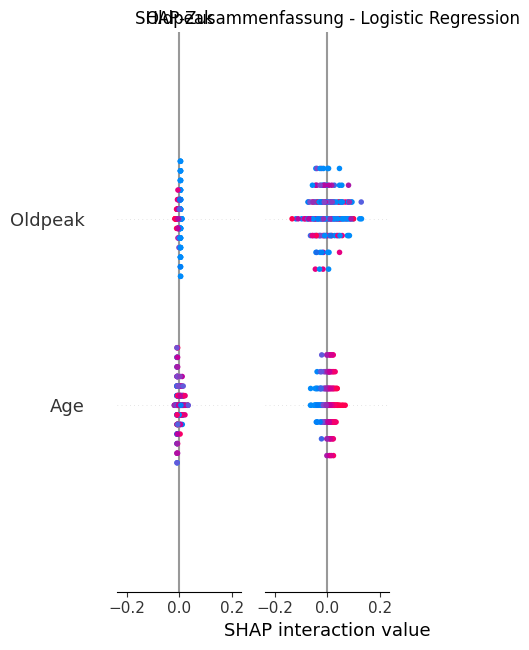


Final Evaluation for Random Forest:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        77
           1       0.89      0.87      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



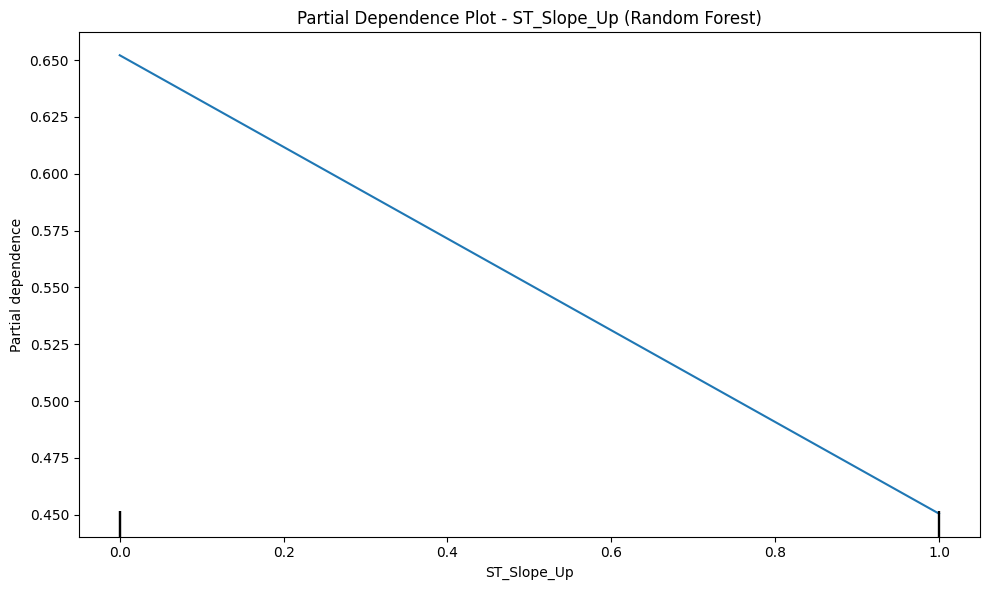

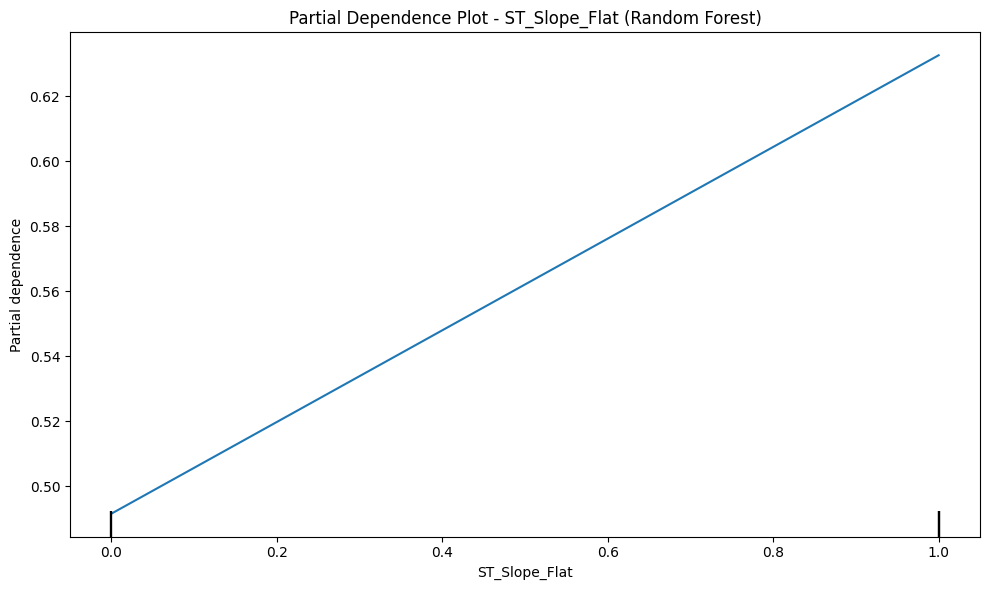

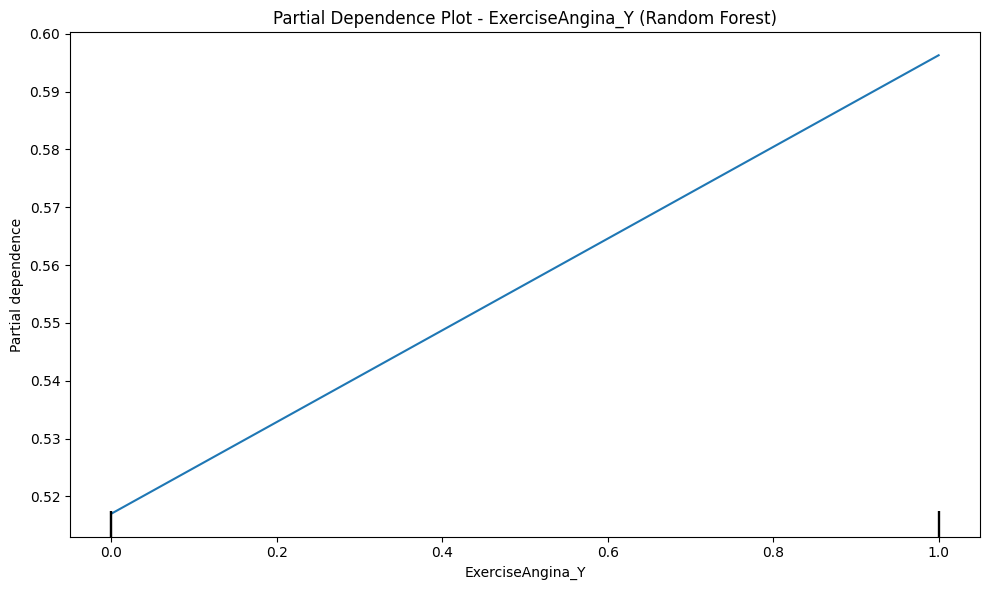

<Figure size 1200x800 with 0 Axes>

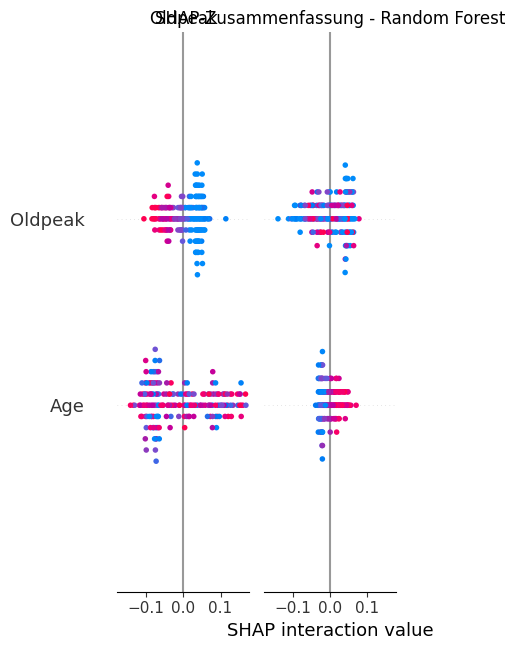


Final Evaluation for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        77
           1       0.90      0.84      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184



Feature importance not available for Support Vector Machine


100%|██████████| 184/184 [16:20<00:00,  5.33s/it]


<Figure size 1200x800 with 0 Axes>

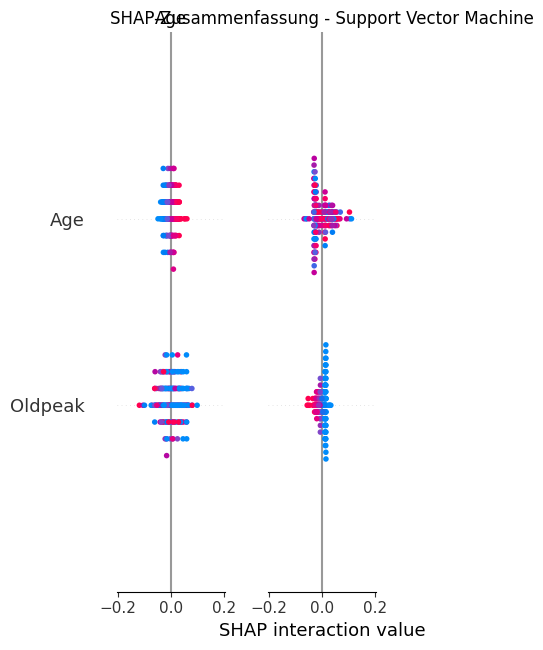


Final Evaluation for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        77
           1       0.90      0.87      0.89       107

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



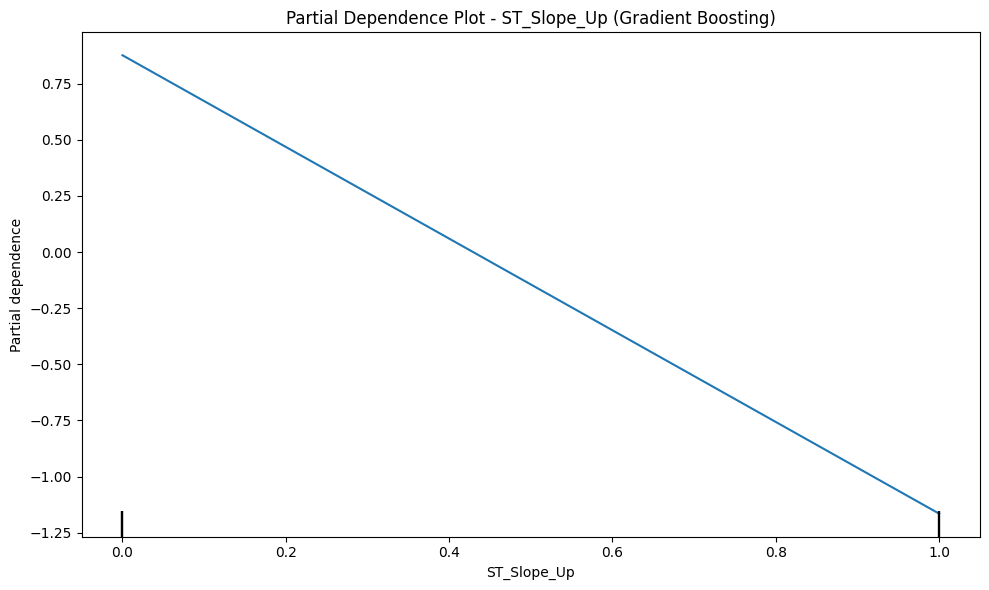

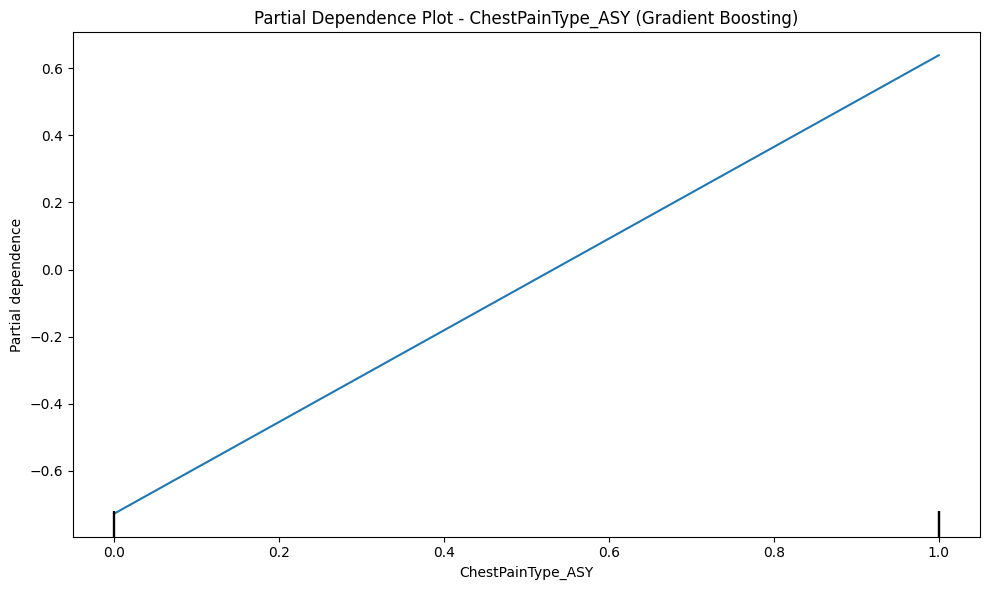

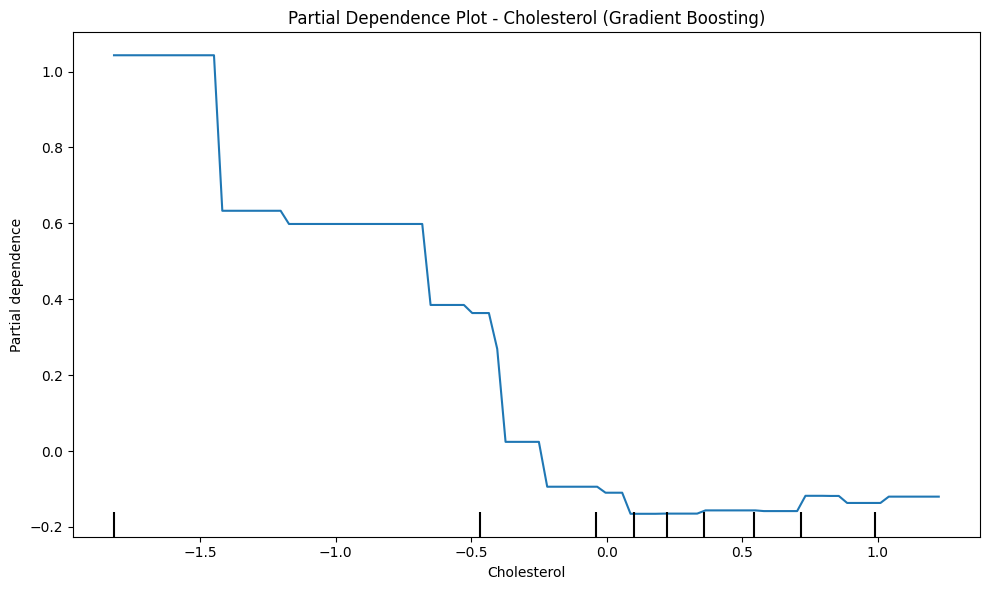

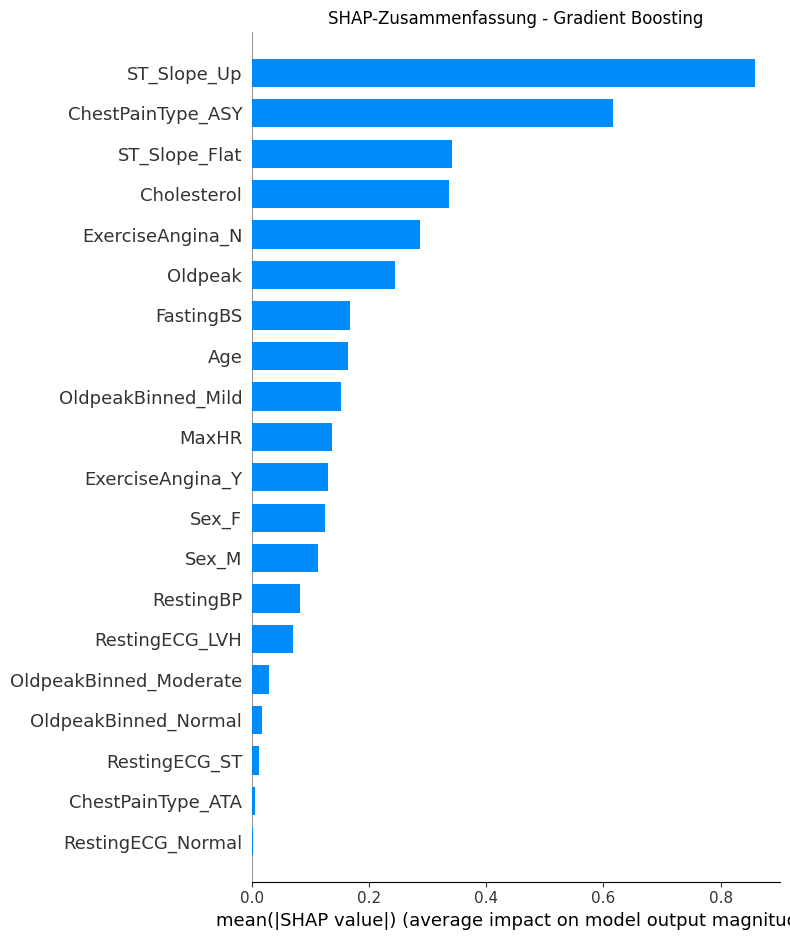


Final Evaluation for XGBoost:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        77
           1       0.90      0.88      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184



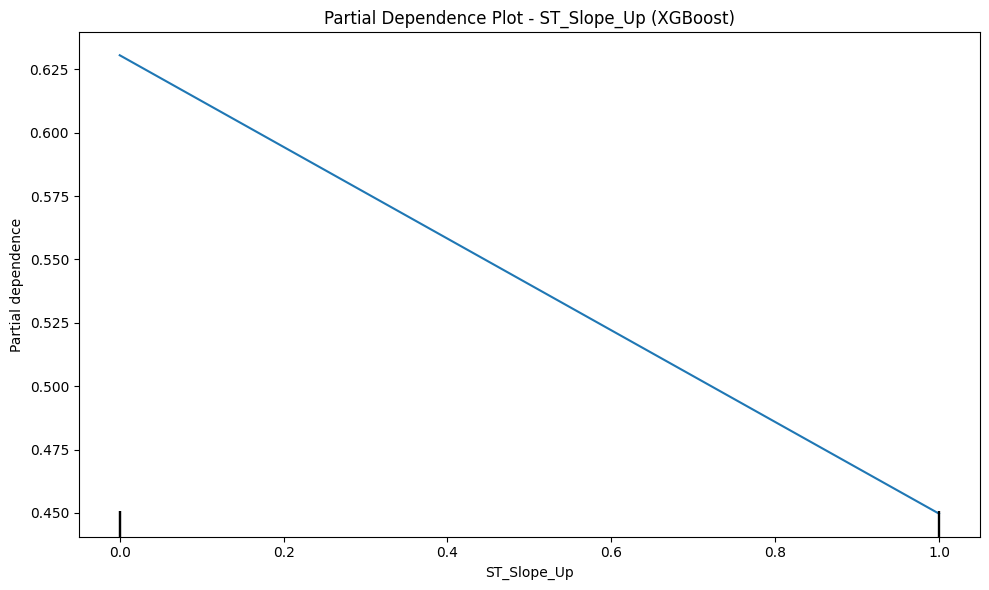

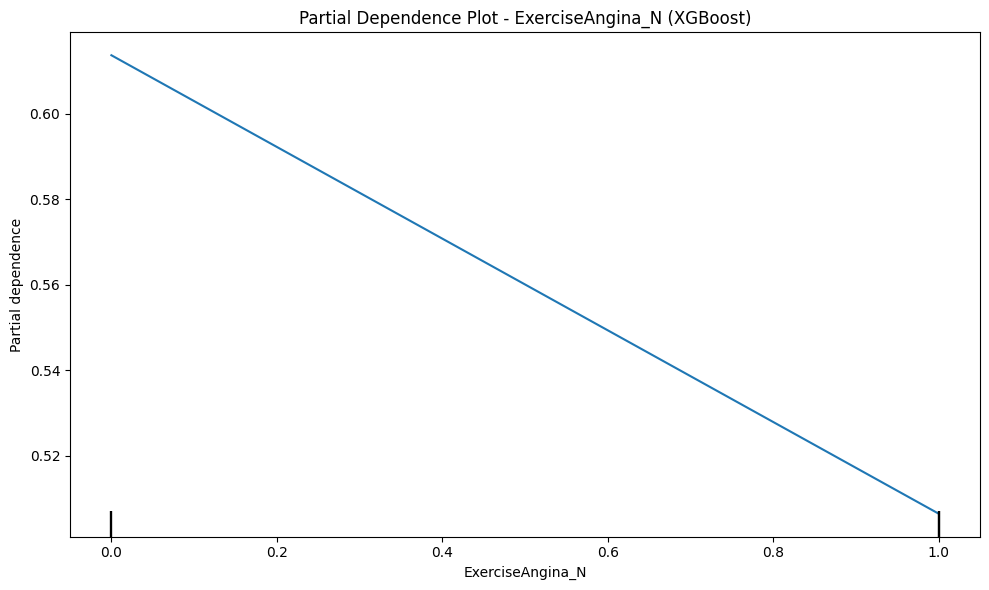

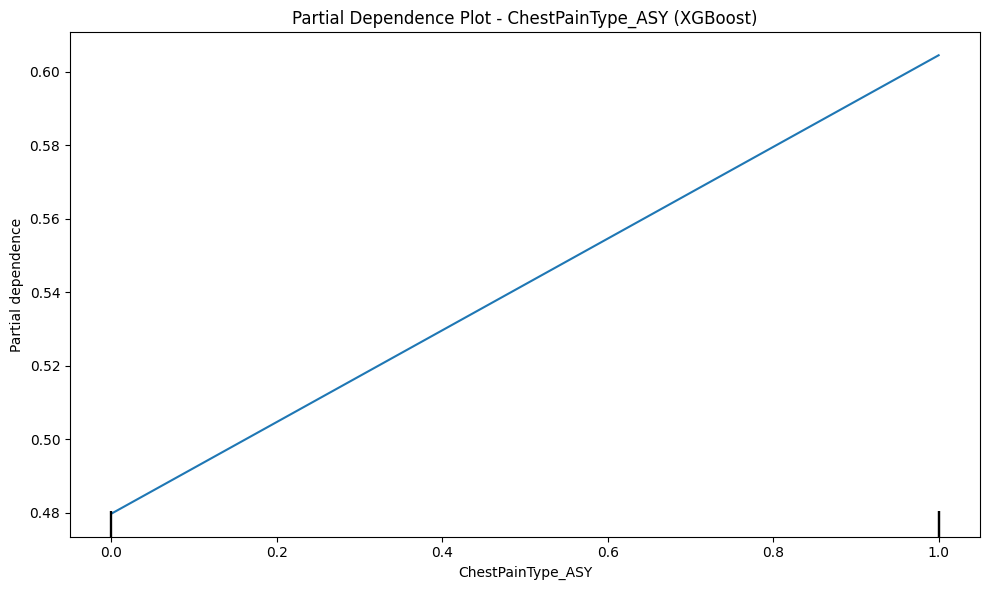

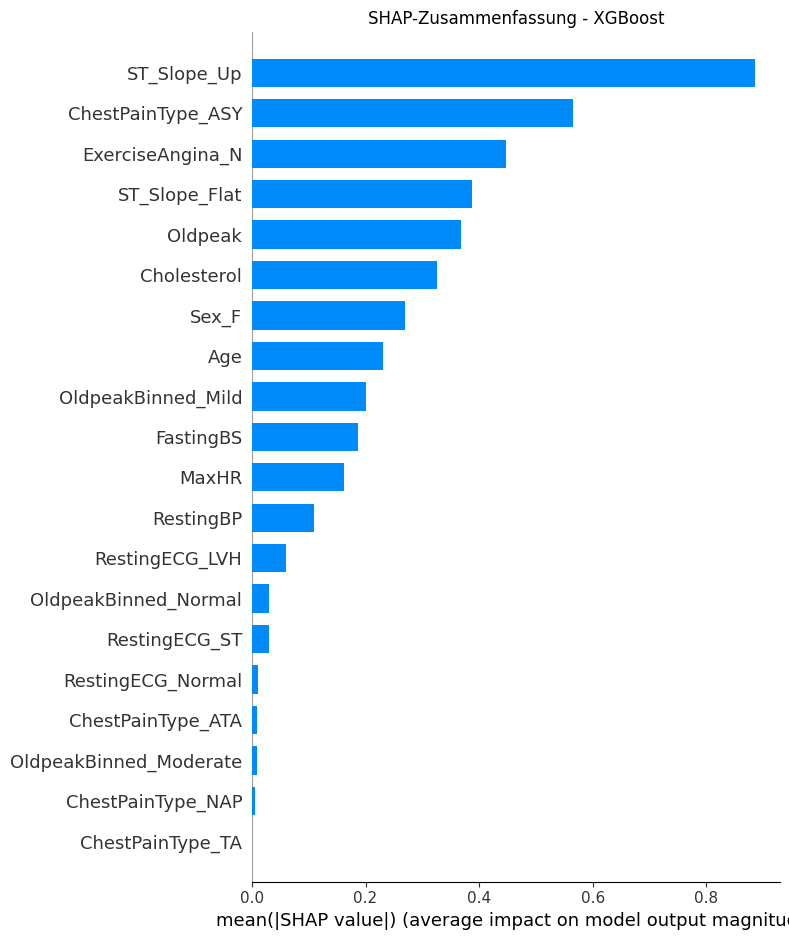

In [730]:
# Finale Evaluation und Visualisierungen
accuracies = {}
auc_scores = {}
for name, model in best_models.items():
    print(f"\nFinal Evaluation for {name}:")
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_pred))
    
    # Konfusionsmatrix
    cm_fig = plot_confusion_matrix_plotly(y_test, y_pred, name)
    cm_fig.show()
    
    # Feature Importance
    fi_fig = plot_feature_importance(model, X_train, name)
    if fi_fig:
        fi_fig.show()
    
    # Partial Dependence Plots (für die Top 3 Features)
    if hasattr(model, 'feature_importances_'):
        top_features = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_})
        top_features = top_features.sort_values('importance', ascending=False).head(3)
        for feature in top_features['feature']:
            plot_pdp(model, X_train, feature, name)

    # SHAP-Summary-Plot hinzufügen
    plot_shap_summary(model, X_test, name)
    
    accuracies[name] = model.score(X_test, y_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_scores[name] = auc(fpr, tpr)

### ROC

In [731]:
# ROC Curves
roc_fig = plot_roc_curves(best_models, X_test, y_test)
roc_fig.show()



#### Accuracy und AUC

In [732]:
# Gesamtvergleich aller Modelle (Accuracy und AUC)
comparison_fig = plot_model_comparison_plotly(accuracies, auc_scores)
comparison_fig.show()



### Korrelationsmatrix

In [733]:
# Korrelationsmatrix
corr_fig = plot_correlation_matrix(X_train)
corr_fig.show()

In [734]:
### Shap Werte